# Time Series Analysis of Bitcoin Prices

# OBJECTIVE
Bitcoin is the largest cryptocurrency by market capitalization.Bitcoin transactions are recorded in a public distributed ledger called a blockchain. It is a pretty controversial digital currency and has been described as an economic bubble by famous economists and an unproductive asset by investor Warren Buffett. 
In this project we are trying to analyze the price changes in Bitcoin by applying **time series models, granger causality and linear regression**. 
The data has been taken from **1st January 2018 to 30th June 2022 from yahoofinance**.

In [203]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams["figure.figsize"]=(15,10)
import math
import plotly.graph_objects as go
from sklearn.linear_model import LinearRegression 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
import yfinance as yf
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')
from matplotlib.image import imread

In [195]:
bitcoin=imread("bitcoin.jpg")

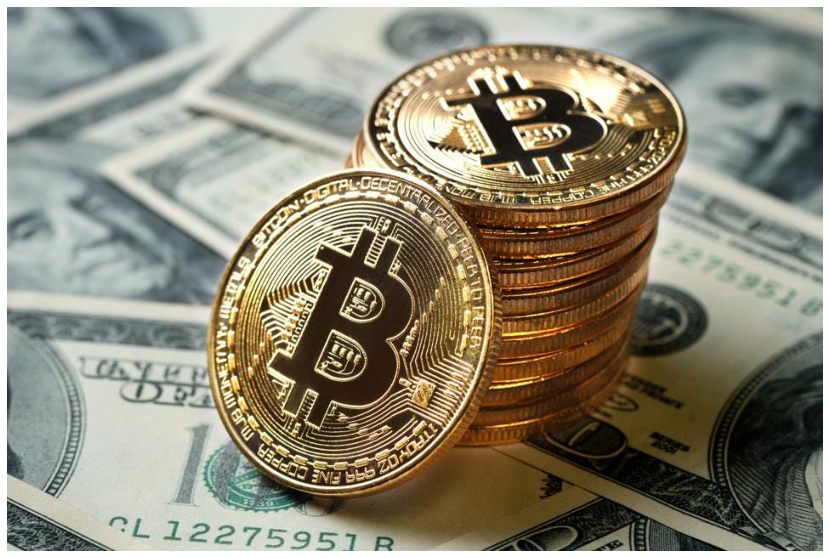

In [199]:
plt.imshow(bitcoin)
plt.axis("off")
plt.show()

 We are writing 2 functions-get_data() to get finance data from 2018-01-01 to 2022-06-30.The 2nd function candlestick() is to generate candlestick patterns of a specific series

In [28]:
def get_data(ticker):
    df= yf.download(ticker, '2018-01-01', '2022-6-30', auto_adjust=False)
    df.index=pd.to_datetime(df.index)
    return df

def candlestick(df):
    fig = go.Figure(data=[go.Candlestick(x=df.index,
                open=df['Open'],
                high=df['High'],
                low=df['Low'],
                close=df['Close'])])
    fig.show()

In [29]:
btc=get_data('BTC-USD')

[*********************100%***********************]  1 of 1 completed


In [30]:
btc

Open          High           Low         Close  \
Date                                                                 
2017-12-31  12897.700195  14377.400391  12755.599609  14156.400391   
2018-01-01  14112.200195  14112.200195  13154.700195  13657.200195   
2018-01-02  13625.000000  15444.599609  13163.599609  14982.099609   
2018-01-03  14978.200195  15572.799805  14844.500000  15201.000000   
2018-01-04  15270.700195  15739.700195  14522.200195  15599.200195   
...                  ...           ...           ...           ...   
2022-06-25  21233.609375  21520.914062  20964.585938  21502.337891   
2022-06-26  21496.494141  21783.724609  21016.269531  21027.294922   
2022-06-27  21028.238281  21478.089844  20620.199219  20735.478516   
2022-06-28  20731.544922  21164.423828  20228.812500  20280.634766   
2022-06-29  20281.169922  20364.156250  19937.791016  20104.023438   

               Adj Close       Volume  
Date                                   
2017-12-31  14156.400391  12136299520  
2018-01-01  13657.200195  10291200000  
2018-01-02  14982.099609  16846600192  
2018-01-03  15201.000000  16871900160  
2018-01-04  15599.200195  21783199744  
...                  ...          ...  
2022-06-25  21502.337891  18372538715  
2022-06-26  21027.294922  18027170497  
2022-06-27  20735.478516  20965695707  
2022-06-28  20280.634766  21381535161  
2022-06-29  20104.023438  23552740328  

[1642 rows x 6 columns]

In [31]:
candlestick(btc)

In [32]:
btc_close=pd.DataFrame(btc["Close"])

In [33]:
btc_close.columns=["BTC"]

In [34]:
len(btc_close)

1642

<AxesSubplot:xlabel='Date'>

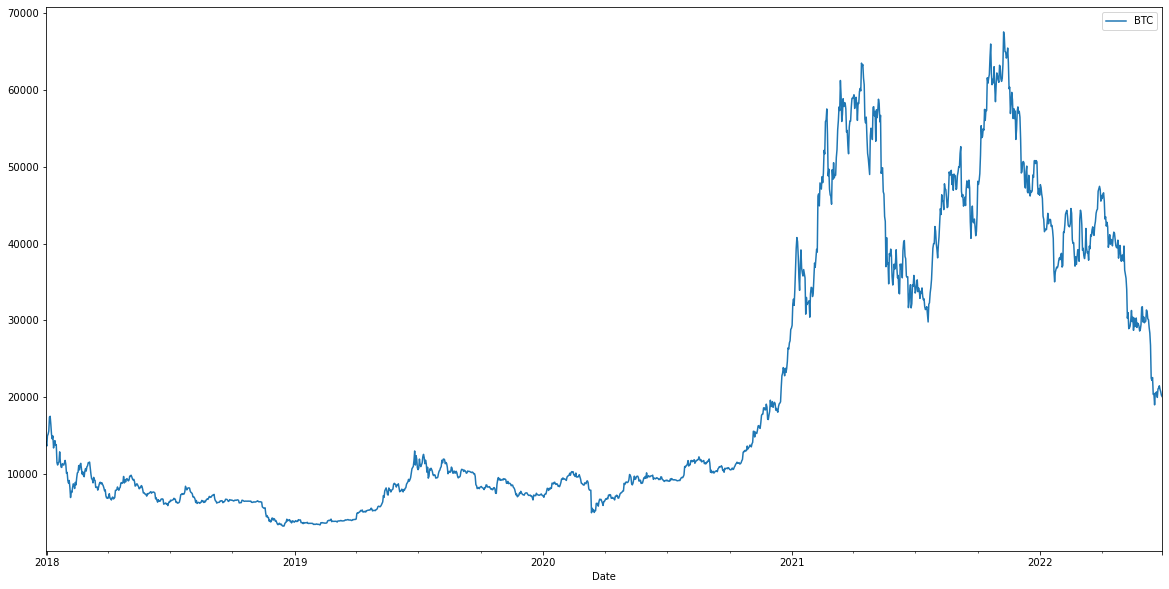

In [35]:
btc_close.plot()

In [36]:
#importing statistical packages
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics import tsaplots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima.utils import ndiffs
from pmdarima import model_selection
import pmdarima as pm
from sklearn.model_selection import train_test_split

# Decomposing into trend,seasonality and random component

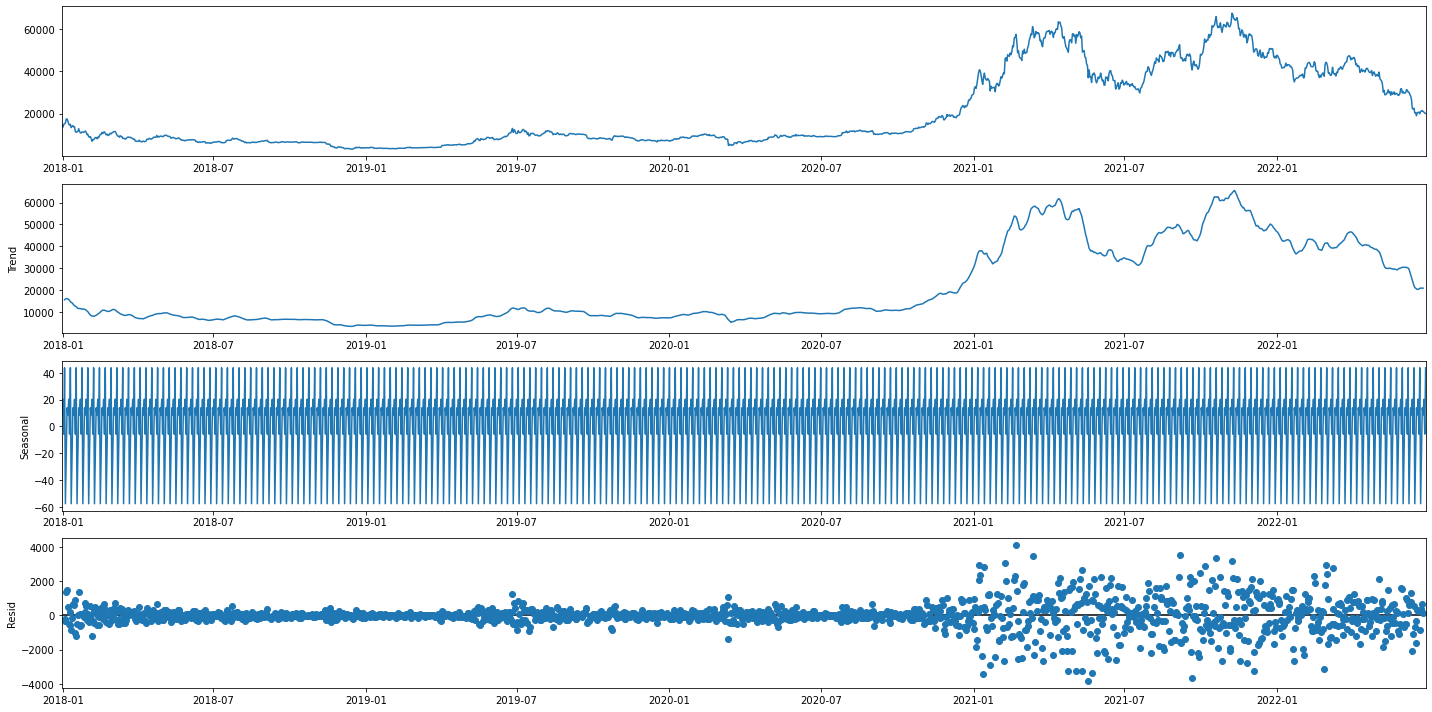

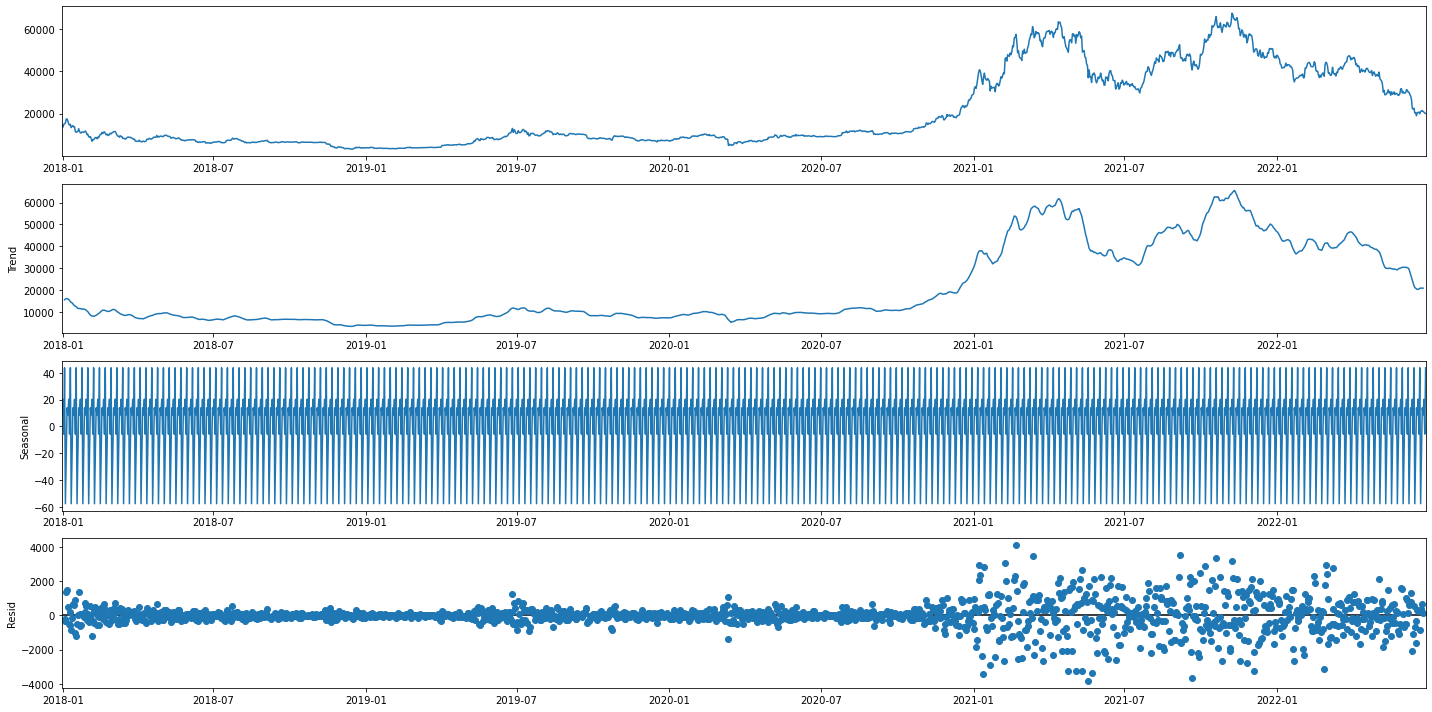

In [37]:
sm.tsa.seasonal_decompose(btc_close).plot()

By default, the decomposition is additive decomposition, which means the series value=trend+seasonal component + random component

We have created 2 functions, adftest and split_data.
The function adftest is to check if a time series is stationary.The function split_data is to split a time series into training set and test set

In [38]:
def adftest(series):
    result=adfuller(series)
    print(result)
    print(f'ADF Statistic:{result[0]}')
    print(f'p-value:{result[1]}')
    if(result[1]>0.05):
        print("Series is not stationary")
    else:
        print("Series is stationary")

This is a function we have created to test for stationarity of a time series using the ADF test.
ADF test is a unit root test where our null hypothesis is our series has a unit root,hence it is not stationary.So if we get an associated **p value>0.05,that means that we accept the null hypothesis at 95% confidence level.Which means that we conclude that based on the evidence we have, our series is not stationary**

In [39]:
#function to split data
def split_data(series):
    train_length=math.ceil(len(series)*0.9)
    train=series.iloc[:train_length+1,:]
    test=series.iloc[train_length+1:,:]
    test_length=len(test)
    train_length=len(train)
    return(train_length,test_length,train,test)

This is a function we have created to split the time series data into train set and test set. The length of training set will be around 90% of the total length of data

We are testing for stationarity of the closing prices of bitcoin

In [40]:
adftest(btc_close)

(-1.3159108907299564, 0.6218619909096383, 24, 1617, {'1%': -3.4344005326727904, '5%': -2.8633290746707947, '10%': -2.5677224657808253}, 27045.82855290978)
ADF Statistic:-1.3159108907299564
p-value:0.6218619909096383
Series is not stationary


Since series is **not stationary**, we are differencing the series by one and checking for stationarity 

In [41]:
btc_diff=btc_close-btc_close.shift()

In [42]:
btc_diff=btc_diff.dropna()

<AxesSubplot:xlabel='Date'>

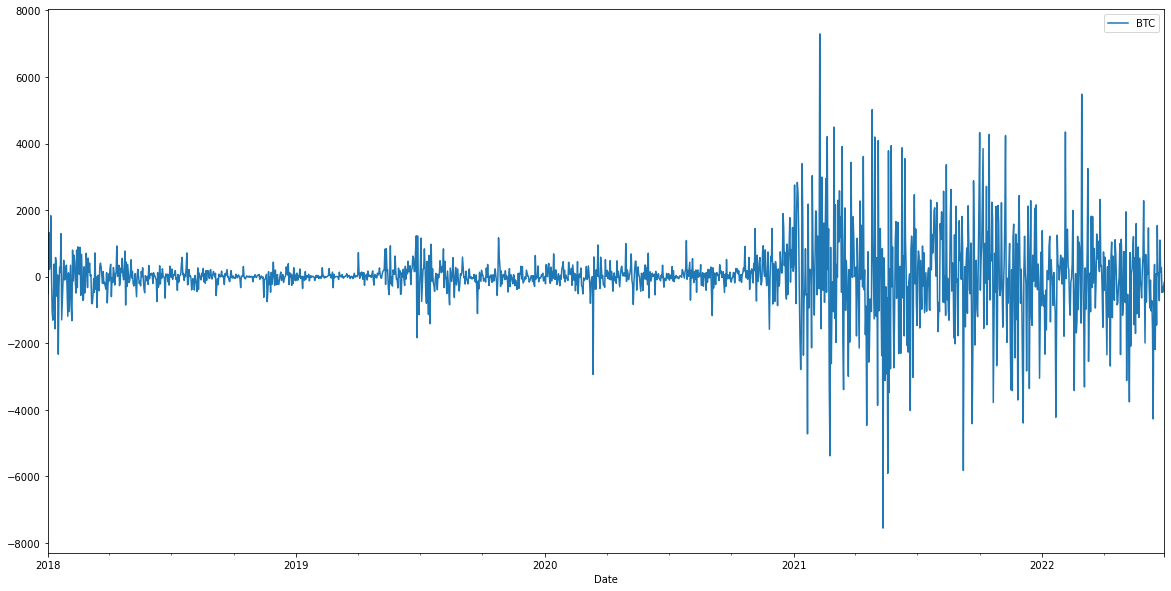

In [43]:
btc_diff.plot()

In [44]:
adftest(btc_diff)

(-7.734056798518177, 1.105695059384927e-11, 23, 1617, {'1%': -3.4344005326727904, '5%': -2.8633290746707947, '10%': -2.5677224657808253}, 27029.814663976093)
ADF Statistic:-7.734056798518177
p-value:1.105695059384927e-11
Series is stationary


After differencing the series by one, we found out that the resulting series is **stationary**.

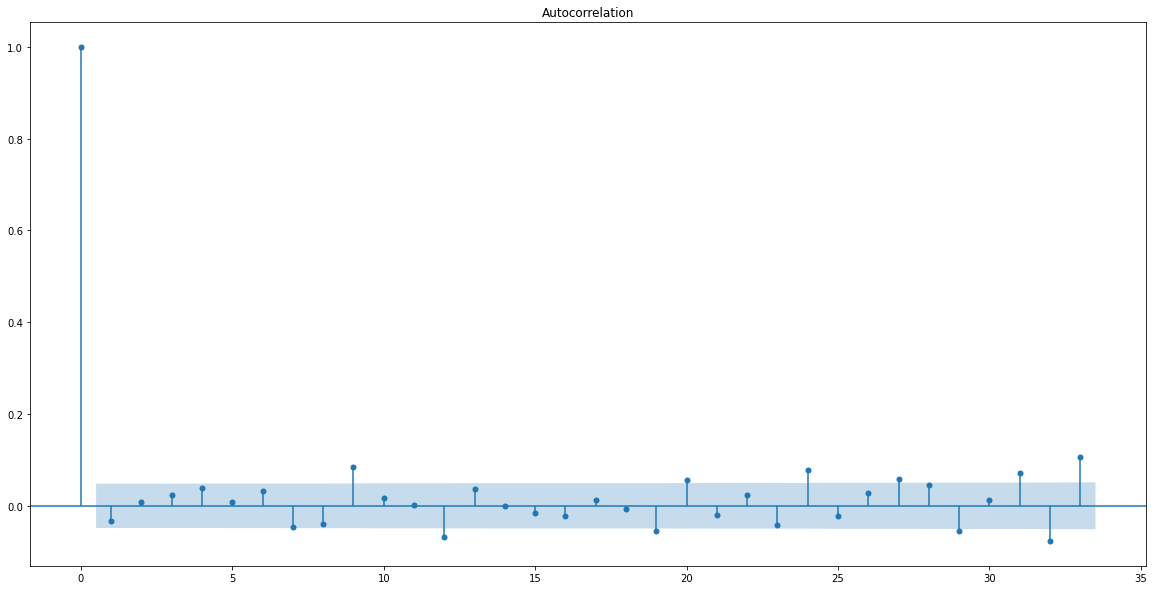

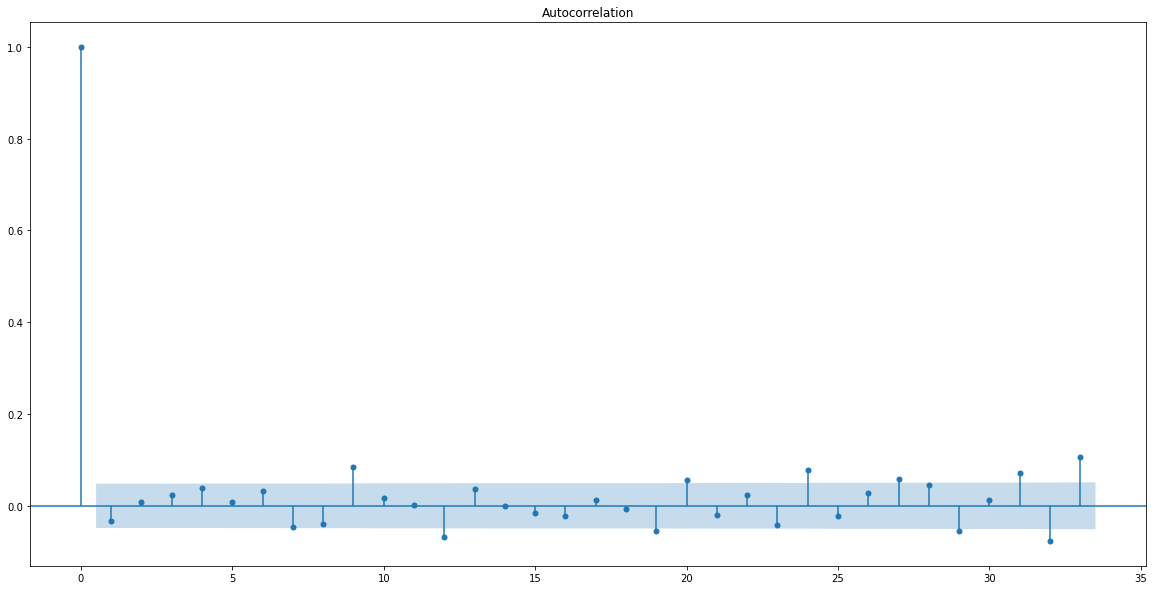

In [45]:
plot_acf(btc_diff)

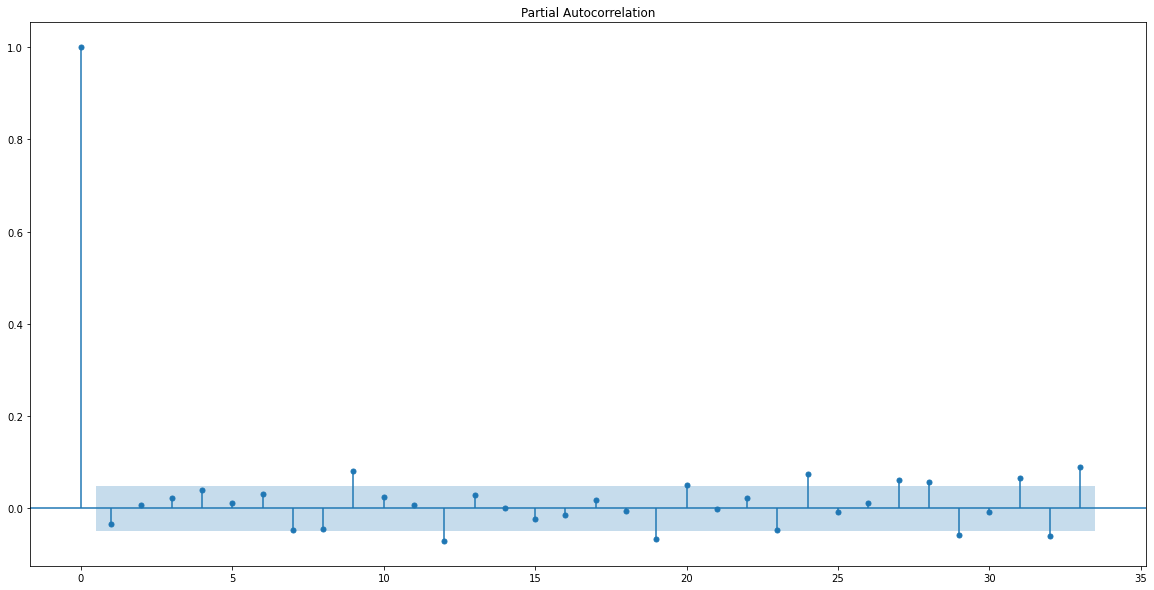

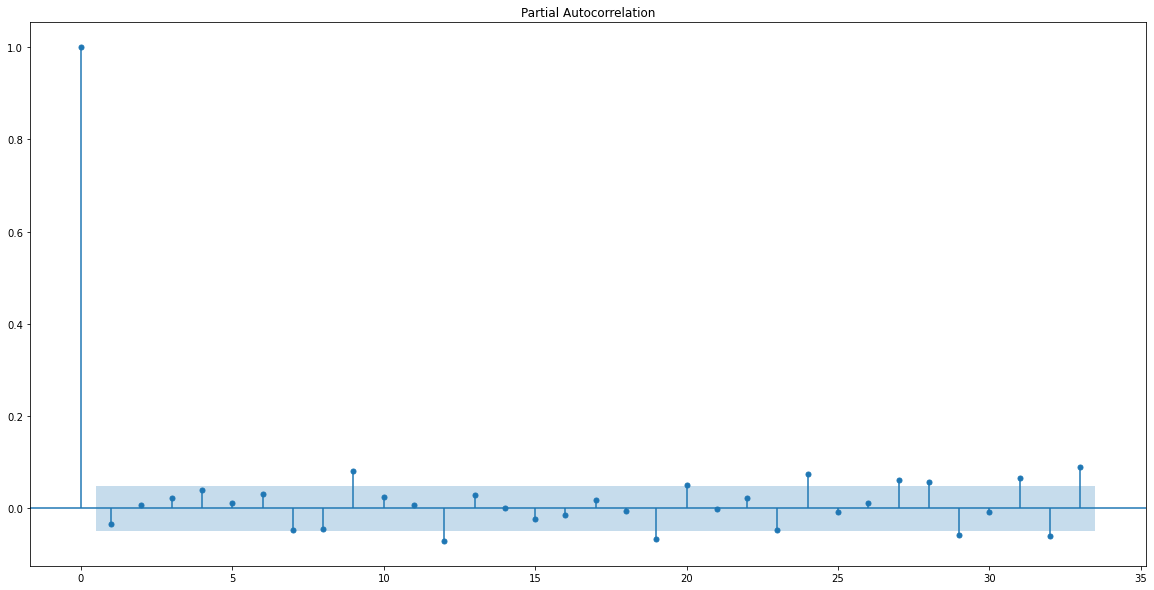

In [46]:
plot_pacf(btc_diff)

We can see that **lag 9** correlation and partial auto-correlation is significant from the acf and pacf plots. But creating a model with so many parameters won't be a nice decision and it would be very complex. So we are putting the training set in the auto_arima to get an idea about the best available parameters to fit the series

In [47]:
train_length,test_length,train,test=split_data(btc_close)

In [48]:
train_length,test_length

(1479, 163)

In [49]:
len(btc_close)

1642

In [50]:
train

BTC
Date                    
2017-12-31  14156.400391
2018-01-01  13657.200195
2018-01-02  14982.099609
2018-01-03  15201.000000
2018-01-04  15599.200195
...                  ...
2022-01-13  42591.570312
2022-01-14  43099.699219
2022-01-15  43177.398438
2022-01-16  43113.878906
2022-01-17  42250.550781

[1479 rows x 1 columns]

In [51]:
test

BTC
Date                    
2022-01-18  42375.632812
2022-01-19  41744.328125
2022-01-20  40680.417969
2022-01-21  36457.316406
2022-01-22  35030.250000
...                  ...
2022-06-25  21502.337891
2022-06-26  21027.294922
2022-06-27  20735.478516
2022-06-28  20280.634766
2022-06-29  20104.023438

[163 rows x 1 columns]

In [52]:
modl = pm.auto_arima(train)

In [53]:
modl

ARIMA(order=(2, 1, 2), scoring_args={}, suppress_warnings=True)

so we get the available parameters **p=2,d=1 and q=2**.But this does not guarantee that they would be the best possible results

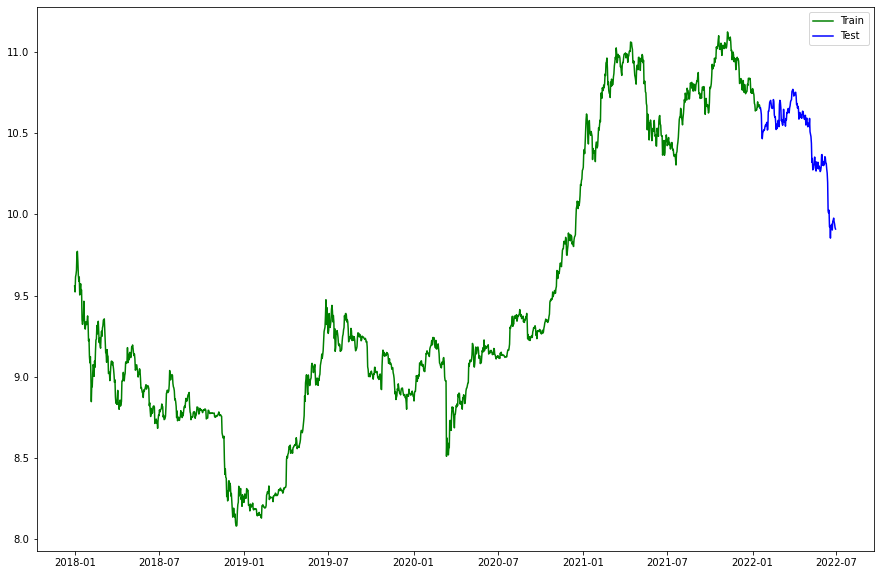

In [204]:
plt.plot(train,"green",label="Train")
plt.plot(test,"blue",label="Test")
plt.legend()

# # arima_summary function 
This function is used to make predictions using ARIMA of order p,d,q. We have a test set and an initial training set. We fit the model into the training set and make a prediction.We find out the metrics and also find out the behaviour of the residuals

In [55]:
def arima_summary(train,test,p,d,q):
    train_array=train.values.flatten()
    test_array=test.values.flatten()
    history = [x for x in train_array]
    predictions =[]
    # walk-forward validation
    for t in range(len(test)):
        model = ARIMA(history, order=(p,d,q))
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0][0]
        predictions.append(yhat)
        obs = test_array[t]
        history.append(obs)
    # evaluate forecasts
    rmse = np.sqrt(mean_squared_error(test, predictions))
    print('Test RMSE: %.3f' % rmse)
    r2=r2_score(test,predictions)
    print("Test R2_score: %.3f" %r2)
    # plot forecasts against actual outcomes
    series=pd.concat([pd.Series(test_array),pd.Series(predictions)],axis=1)
    series.columns=["actual","predicted"]
    series.plot()
    series["resid"]=series["actual"]-series["predicted"]
    print(series)
    fig, axs = plt.subplots(1,1)
    axs.plot(series["resid"])
    print(adftest(series["resid"]))

In [189]:
img=imread("forward chaining cross validation.JPG")

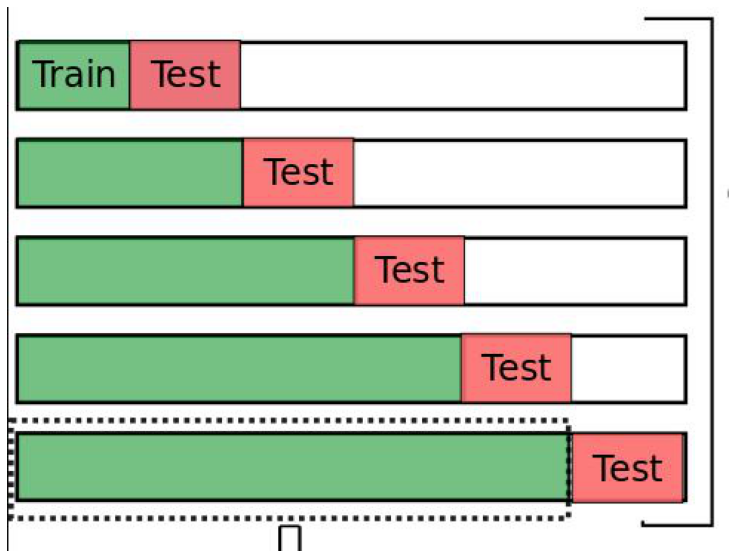

In [200]:
plt.imshow(img)
plt.axis('off')
plt.show()

In [56]:
model=ARIMA(train,order=(2,1,2))
model_fit=model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                  D.BTC   No. Observations:                 1478
Model:                 ARIMA(2, 1, 2)   Log Likelihood              -12305.947
Method:                       css-mle   S.D. of innovations            999.237
Date:                Thu, 04 Aug 2022   AIC                          24623.895
Time:                        20:48:24   BIC                          24655.685
Sample:                    01-01-2018   HQIC                         24635.747
                         - 01-17-2022                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          18.9875     25.904      0.733      0.464     -31.784      69.759
ar.L1.D.BTC     0.9147      0.017     54.116      0.000       0.882       0.948
ar.L2.D.BTC    -0.9464      0.024    -39.750      0.000      -0.993      -0.900
ma.L1.D.BTC    -0.9472      0.011    -86.857      0.000      -0.969      -0.926
ma.L2.D.BTC     0.9754      0.016     60.676      0.000       0.944       1.007
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.4833           -0.9073j            1.0280           -0.1721
AR.2            0.4833           +0.9073j            1.0280            0.1721
MA.1            0.4856           -0.8885j            1.0125           -0.1704
MA.2            0.4856           +0.8885j            1.0125            0.1704
-----------------------------------------------------------------------------
"""

Test RMSE: 1353.056
Test R2_score: 0.966
           actual     predicted        resid
0    42375.632812  42304.308583    71.324229
1    41744.328125  42383.663167  -639.335042
2    40680.417969  41789.293134 -1108.875165
3    36457.316406  40736.202404 -4278.885997
4    35030.250000  36616.374570 -1586.124570
..            ...           ...          ...
158  21502.337891  21239.654920   262.682971
159  21027.294922  21499.748673  -472.453751
160  20735.478516  21049.791741  -314.313226
161  20280.634766  20745.649860  -465.015094
162  20104.023438  20296.965502  -192.942064

[163 rows x 3 columns]
(-12.394618981751867, 4.705516591358339e-23, 0, 162, {'1%': -3.471374345647024, '5%': -2.8795521079291966, '10%': -2.5763733302850174}, 2557.677772798263)
ADF Statistic:-12.394618981751867
p-value:4.705516591358339e-23
Series is stationary
None


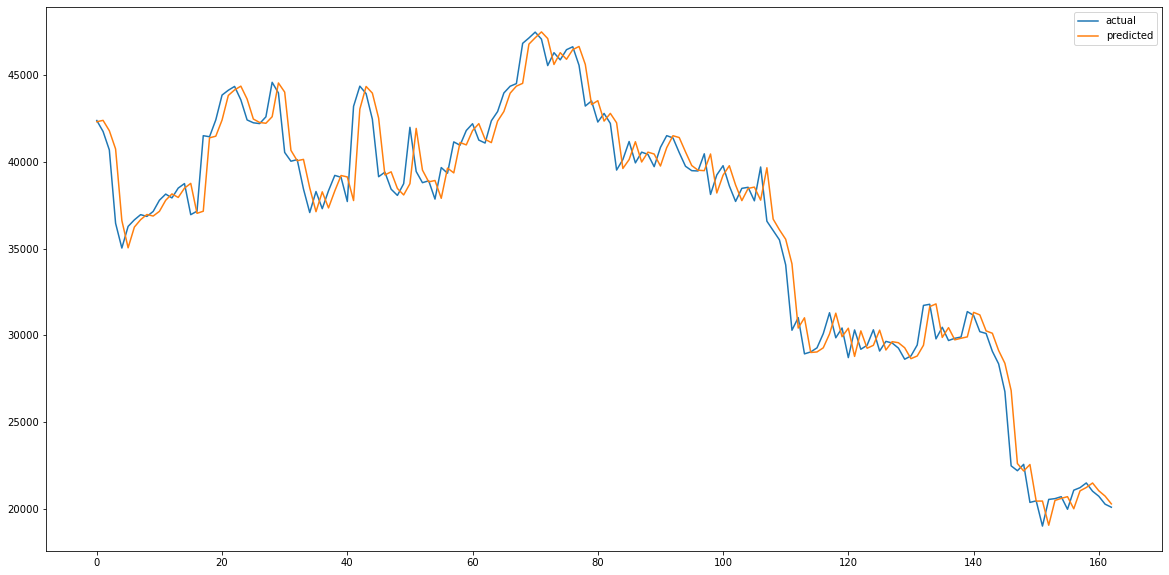

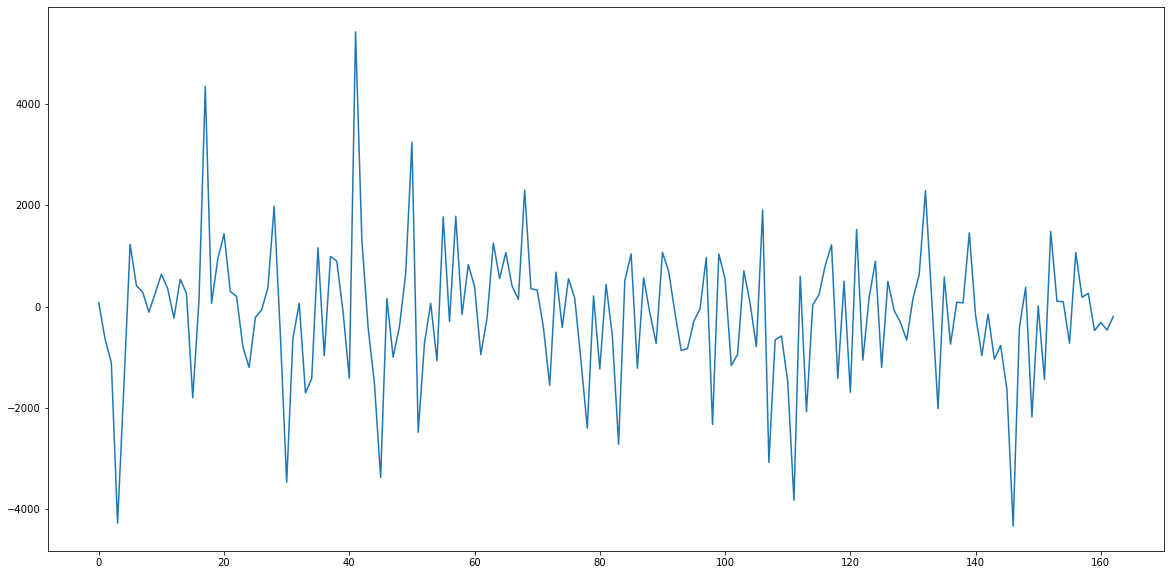

In [62]:
arima_summary(train,test,0,1,2)

# Log transformation
We are transforming into log and checking if we get better results

In [63]:
btc_close1=btc_close.copy()

In [64]:
btc_close=np.log(btc_close)

In [65]:
#splitting the data
train_length,test_length,train,test=split_data(btc_close)
print(train_length)

1479


In [66]:
train

BTC
Date                 
2017-12-31   9.557922
2018-01-01   9.522022
2018-01-02   9.614611
2018-01-03   9.629116
2018-01-04   9.654975
...               ...
2022-01-13  10.659412
2022-01-14  10.671271
2022-01-15  10.673072
2022-01-16  10.671600
2022-01-17  10.651373

[1479 rows x 1 columns]

In [67]:
len(test)

163

In [68]:
test

BTC
Date                 
2022-01-18  10.654329
2022-01-19  10.639319
2022-01-20  10.613502
2022-01-21  10.503897
2022-01-22  10.463967
...               ...
2022-06-25   9.975917
2022-06-26   9.953577
2022-06-27   9.939601
2022-06-28   9.917422
2022-06-29   9.908675

[163 rows x 1 columns]

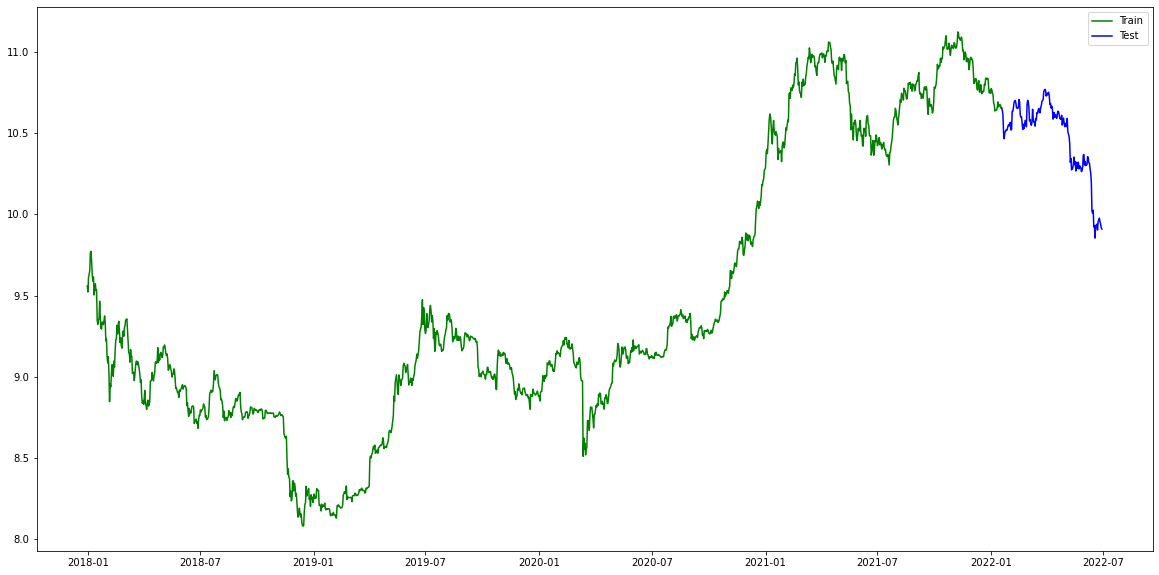

In [69]:
plt.plot(train,"green",label="Train")
plt.plot(test,"blue",label="Test")
plt.legend()

In [70]:
adftest(btc_close)

(-0.9279245358138201, 0.7786374462269197, 8, 1633, {'1%': -3.4343607832380814, '5%': -2.8633115295706735, '10%': -2.5677131231763433}, -5871.925607370574)
ADF Statistic:-0.9279245358138201
p-value:0.7786374462269197
Series is not stationary


#Our time series is not stationary

# We will be differencing by 1 lag and then check stationarity

In [71]:
btc_diff=btc_close-btc_close.shift()

In [72]:
btc_close.shift()

BTC
Date                
2017-12-31       NaN
2018-01-01  9.557922
2018-01-02  9.522022
2018-01-03  9.614611
2018-01-04  9.629116
...              ...
2022-06-25  9.963249
2022-06-26  9.975917
2022-06-27  9.953577
2022-06-28  9.939601
2022-06-29  9.917422

[1642 rows x 1 columns]

In [73]:
btc_diff

BTC
Date                
2017-12-31       NaN
2018-01-01 -0.035900
2018-01-02  0.092589
2018-01-03  0.014505
2018-01-04  0.025858
...              ...
2022-06-25  0.012668
2022-06-26 -0.022340
2022-06-27 -0.013975
2022-06-28 -0.022180
2022-06-29 -0.008747

[1642 rows x 1 columns]

<AxesSubplot:xlabel='Date'>

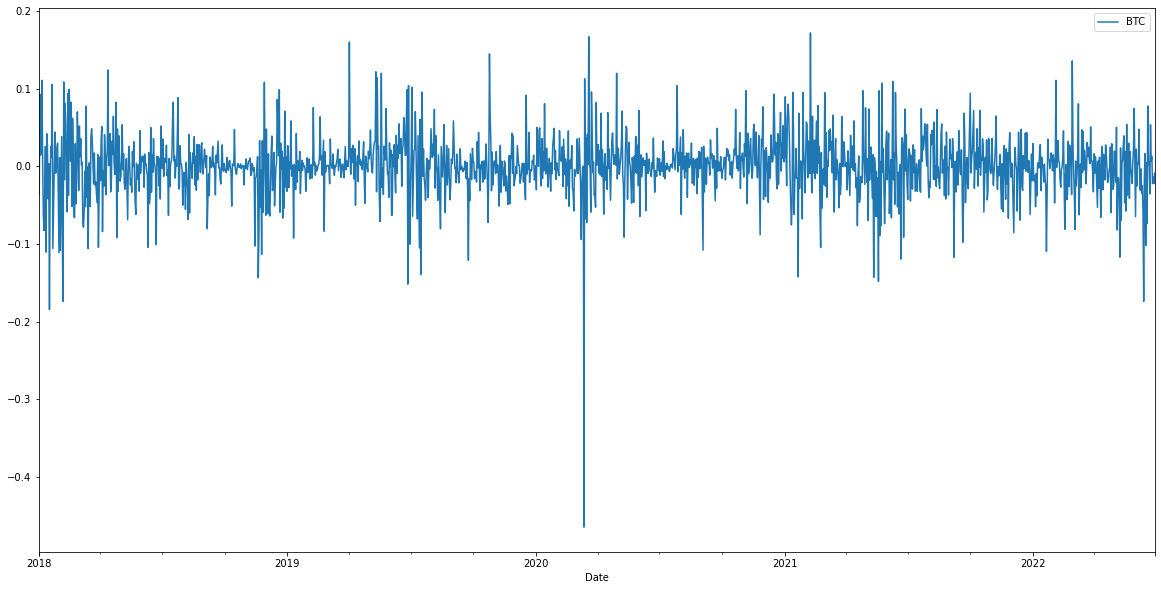

In [74]:
btc_diff.plot()

In [75]:
btc_diff=btc_diff.dropna()

In [76]:
adftest(btc_diff)

(-14.048441616015994, 3.209404064815267e-26, 7, 1633, {'1%': -3.4343607832380814, '5%': -2.8633115295706735, '10%': -2.5677131231763433}, -5868.496304553489)
ADF Statistic:-14.048441616015994
p-value:3.209404064815267e-26
Series is stationary


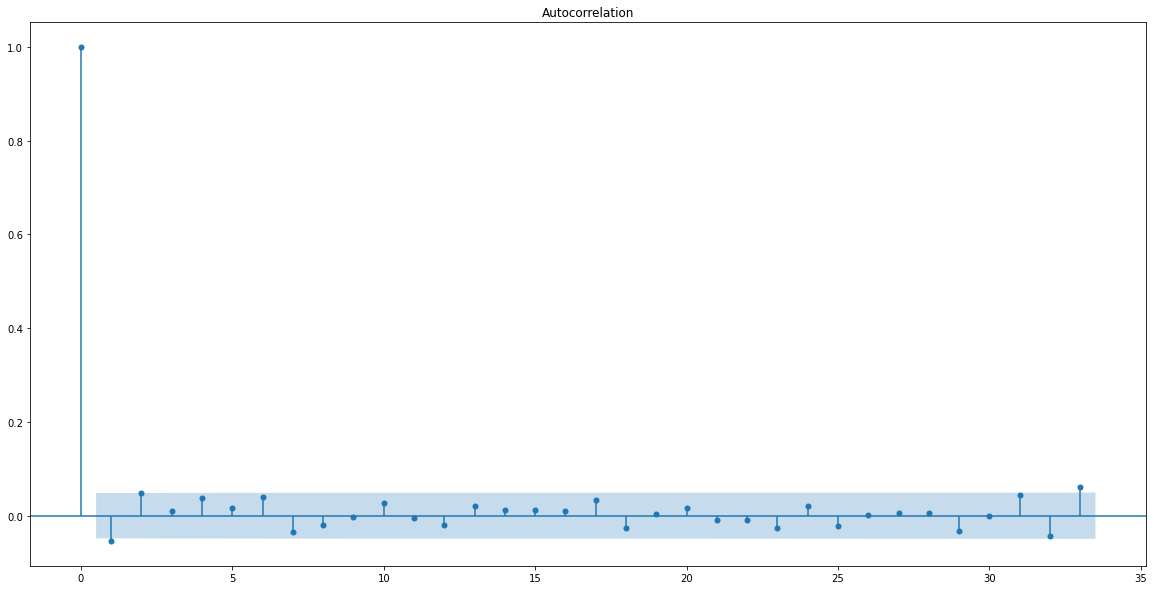

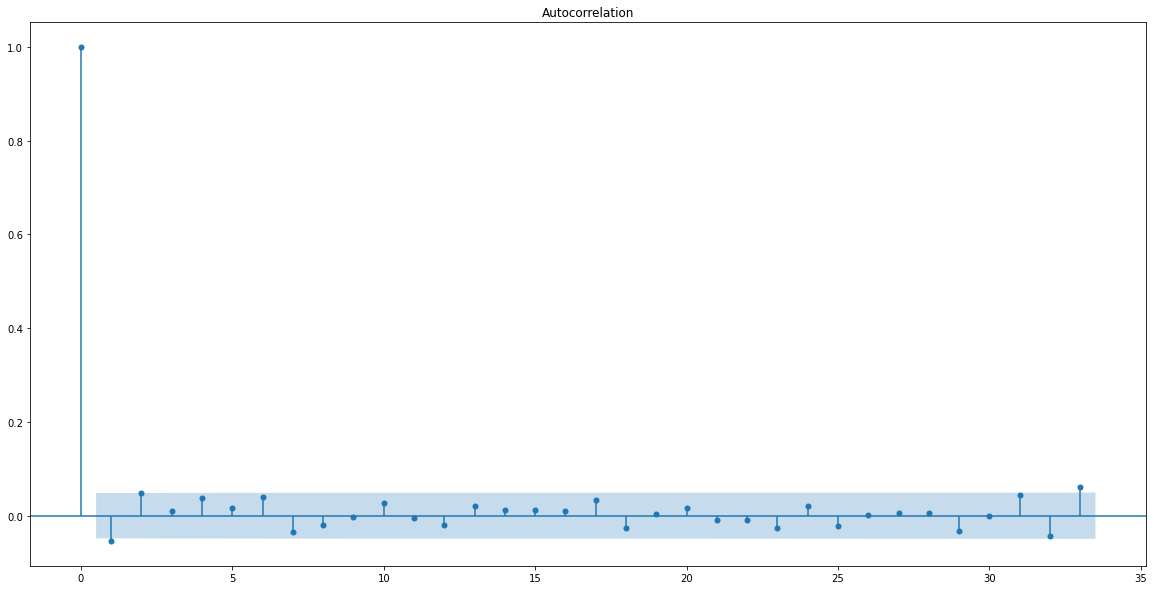

In [77]:
plot_acf(btc_diff)

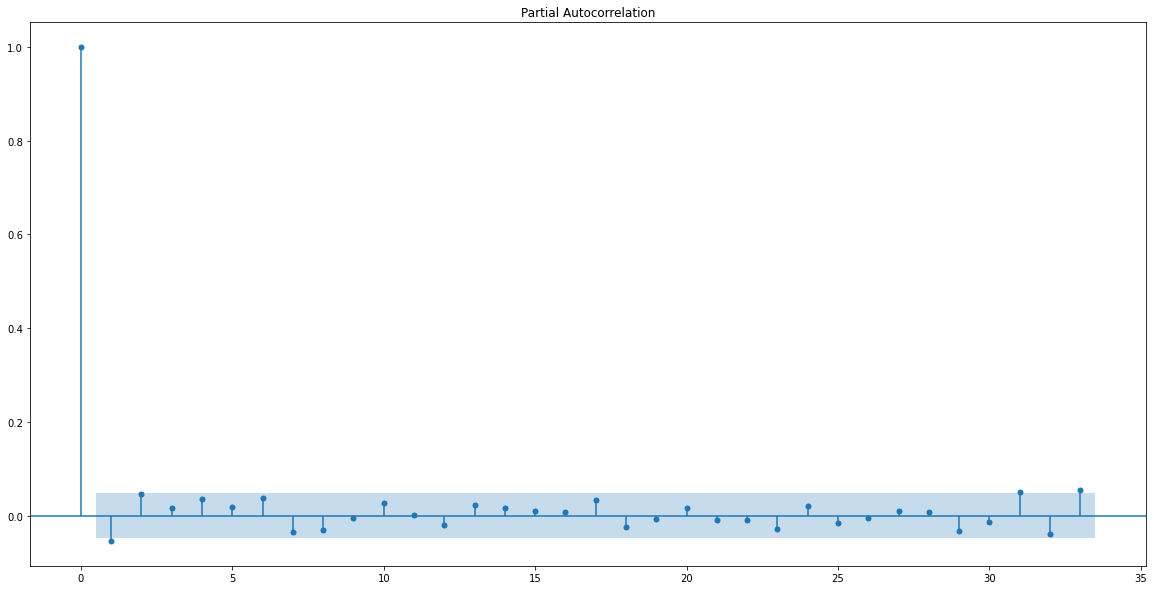

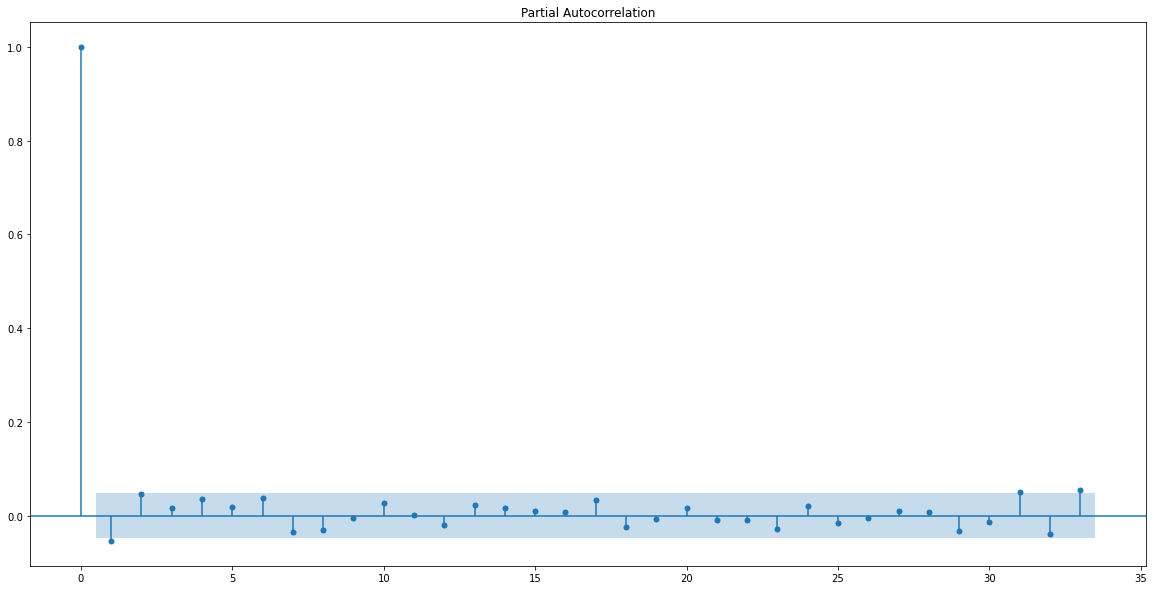

In [78]:
plot_pacf(btc_diff)

# using auto_arima 

In [79]:
modl = pm.auto_arima(train)

In [80]:
modl

ARIMA(order=(2, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

# ARIMA

In [81]:
model=ARIMA(train,order=(2,1,0))
model_fit=model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                  D.BTC   No. Observations:                 1478
Model:                 ARIMA(2, 1, 0)   Log Likelihood                2661.663
Method:                       css-mle   S.D. of innovations              0.040
Date:                Thu, 04 Aug 2022   AIC                          -5315.325
Time:                        20:52:46   BIC                          -5294.132
Sample:                    01-01-2018   HQIC                         -5307.424
                         - 01-17-2022                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0007      0.001      0.722      0.470      -0.001       0.003
ar.L1.D.BTC    -0.0556      0.026     -2.142      0.032      -0.107      -0.005
ar.L2.D.BTC     0.0448      0.026      1.723      0.085      -0.006       0.096
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -4.1432           +0.0000j            4.1432            0.5000
AR.2            5.3847           +0.0000j            5.3847            0.0000
-----------------------------------------------------------------------------
"""

Test RMSE: 0.039
Test R2_score: 0.971
        actual  predicted     resid
0    10.654329  10.653183  0.001145
1    10.639319  10.654009 -0.014691
2    10.613502  10.641029 -0.027527
3    10.503897  10.614983 -0.111086
4    10.463967  10.509303 -0.045336
..         ...        ...       ...
158   9.975917   9.965612  0.010305
159   9.953577   9.975838 -0.022261
160   9.939601   9.955571 -0.015970
161   9.917422   9.939531 -0.022109
162   9.908675   9.918144 -0.009469

[163 rows x 3 columns]
(-12.432157986936213, 3.918561790582756e-23, 0, 162, {'1%': -3.471374345647024, '5%': -2.8795521079291966, '10%': -2.5763733302850174}, -535.7158900547124)
ADF Statistic:-12.432157986936213
p-value:3.918561790582756e-23
Series is stationary
None


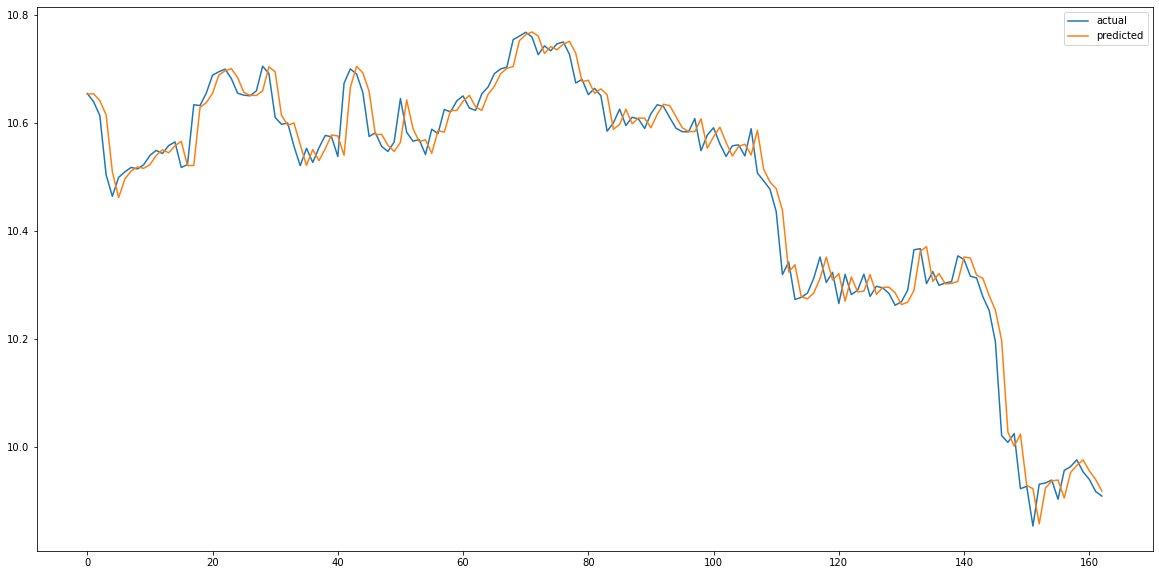

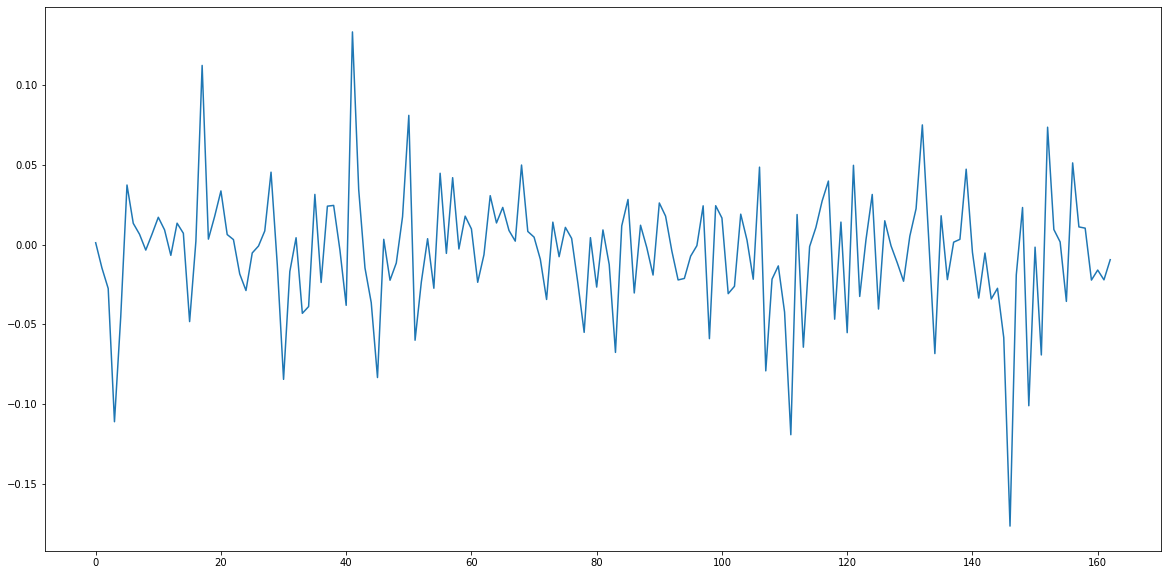

In [82]:
arima_summary(train,test,2,1,0)

Using log transformation, we get a slightly better result on test set

# Granger Causality

Between Bitcoin and Etherium

In [83]:
#getting etherium data
eth=get_data("ETH-USD")

[*********************100%***********************]  1 of 1 completed


In [84]:
eth_close=eth["Close"]

In [85]:
from statsmodels.tsa.stattools import grangercausalitytests

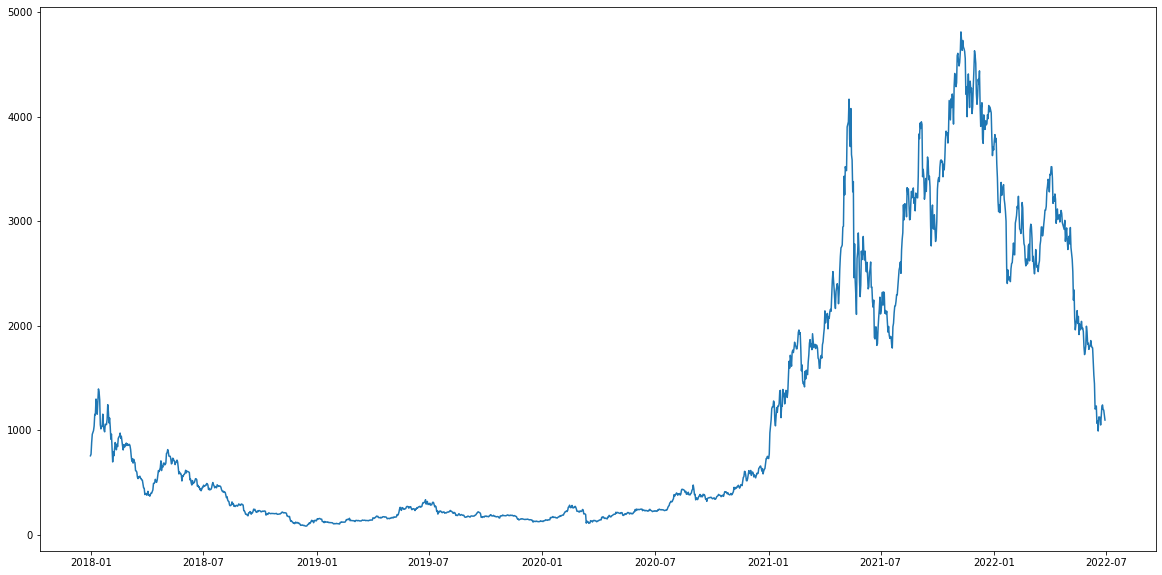

In [86]:
plt.plot(eth_close)

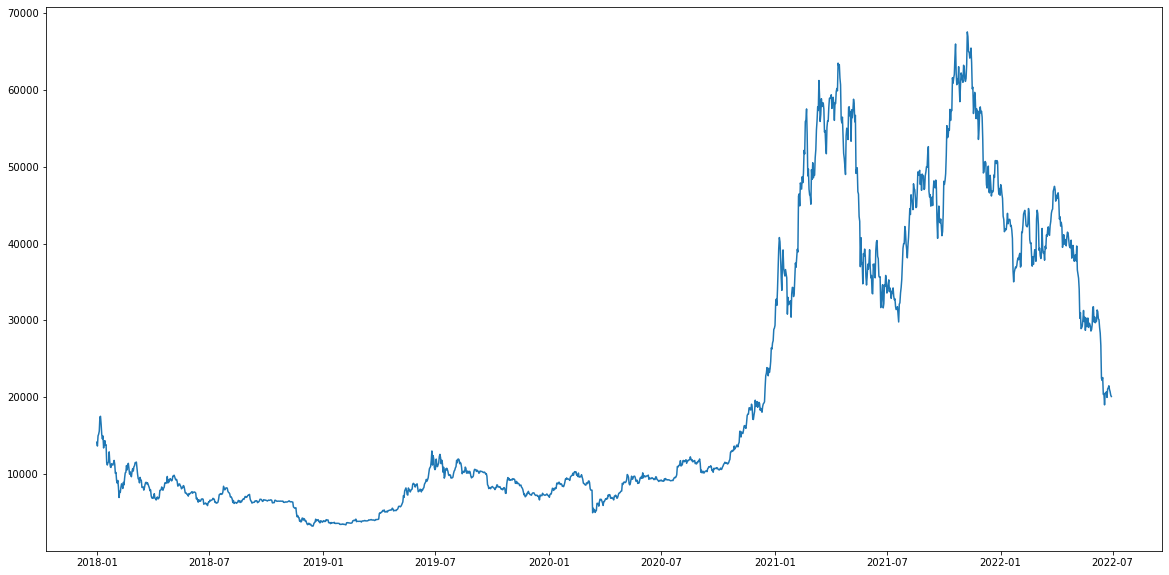

In [87]:
plt.plot(btc_close1)

In [88]:
btc_close1

BTC
Date                    
2017-12-31  14156.400391
2018-01-01  13657.200195
2018-01-02  14982.099609
2018-01-03  15201.000000
2018-01-04  15599.200195
...                  ...
2022-06-25  21502.337891
2022-06-26  21027.294922
2022-06-27  20735.478516
2022-06-28  20280.634766
2022-06-29  20104.023438

[1642 rows x 1 columns]

In [89]:
ts=pd.concat([btc_close1["BTC"],eth_close],axis=1)
ts.columns=["BTC","ETH"]
ts

BTC          ETH
Date                                 
2017-12-31  14156.400391   756.732971
2018-01-01  13657.200195   772.640991
2018-01-02  14982.099609   884.443970
2018-01-03  15201.000000   962.719971
2018-01-04  15599.200195   980.921997
...                  ...          ...
2022-06-25  21502.337891  1243.446899
2022-06-26  21027.294922  1199.831665
2022-06-27  20735.478516  1193.680664
2022-06-28  20280.634766  1144.579224
2022-06-29  20104.023438  1098.943848

[1642 rows x 2 columns]

In [90]:
ts.corr()

BTC       ETH
BTC  1.000000  0.927004
ETH  0.927004  1.000000

In [91]:
ts_diff=ts.diff().dropna()

In [92]:
ts_diff

BTC         ETH
Date                               
2018-01-01  -499.200195   15.908020
2018-01-02  1324.899414  111.802979
2018-01-03   218.900391   78.276001
2018-01-04   398.200195   18.202026
2018-01-05  1830.299805   16.797974
...                 ...         ...
2022-06-25   270.681641   16.602173
2022-06-26  -475.042969  -43.615234
2022-06-27  -291.816406   -6.151001
2022-06-28  -454.843750  -49.101440
2022-06-29  -176.611328  -45.635376

[1641 rows x 2 columns]

<AxesSubplot:xlabel='Date'>

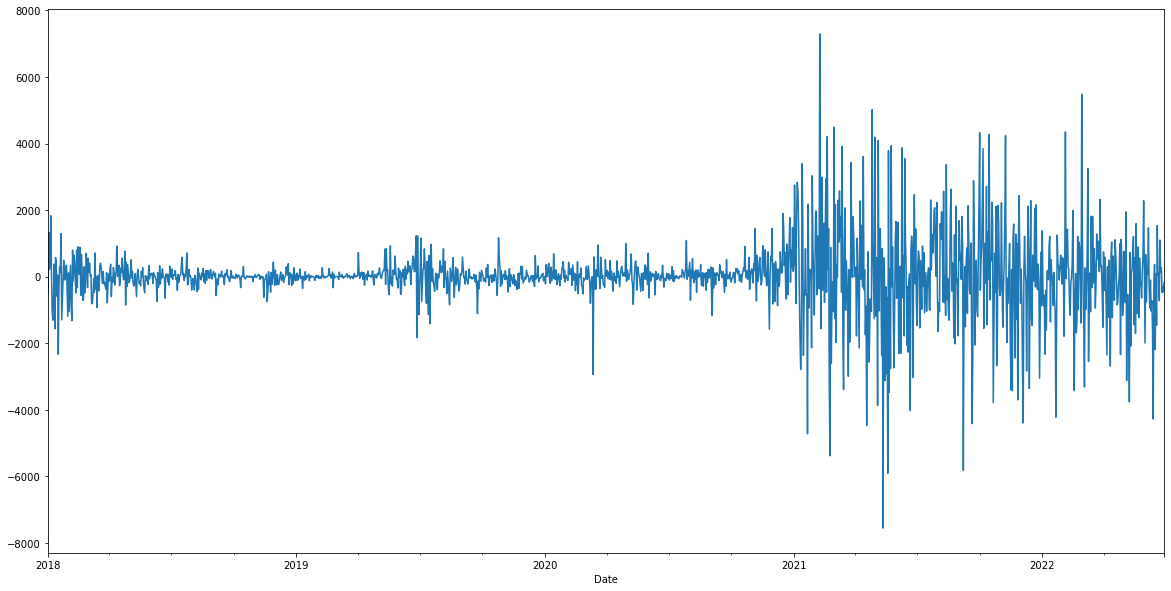

In [93]:
ts_diff.BTC.plot()

<AxesSubplot:xlabel='Date'>

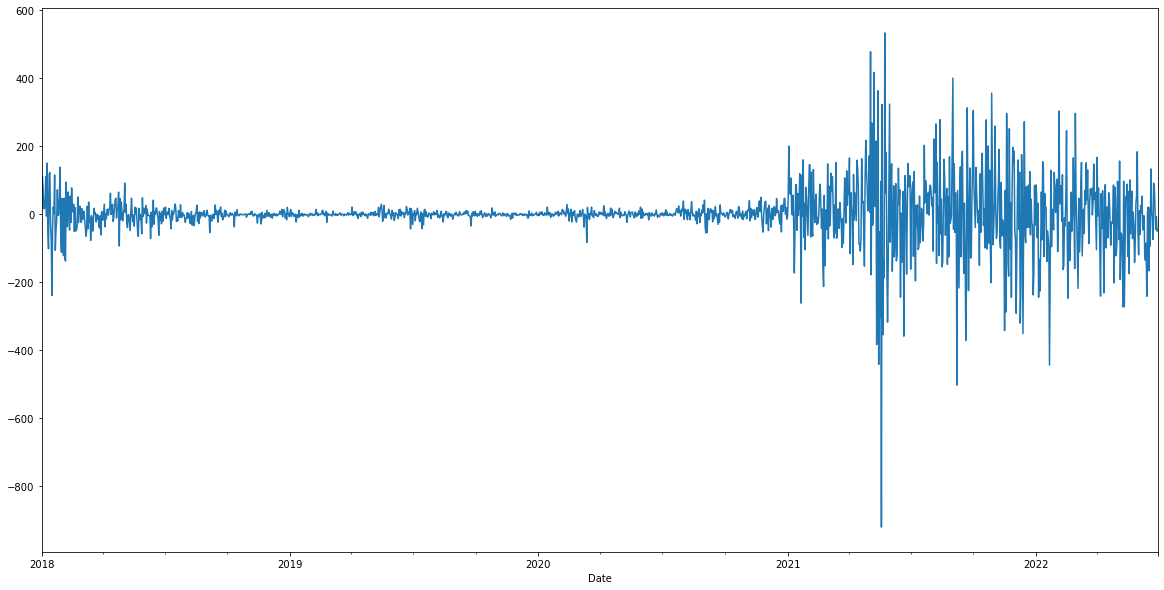

In [94]:
ts_diff.ETH.plot()

In [95]:
adftest(ts_diff.ETH)

(-9.954111087934292, 2.4701672116083686e-17, 16, 1624, {'1%': -3.4343830457666806, '5%': -2.8633213561112156, '10%': -2.5677183557141645}, 18762.879998058856)
ADF Statistic:-9.954111087934292
p-value:2.4701672116083686e-17
Series is stationary


In [96]:
gc_res=grangercausalitytests(ts_diff,3)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=14.2070 , p=0.0002  , df_denom=1637, df_num=1
ssr based chi2 test:   chi2=14.2330 , p=0.0002  , df=1
likelihood ratio test: chi2=14.1716 , p=0.0002  , df=1
parameter F test:         F=14.2070 , p=0.0002  , df_denom=1637, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=7.5645  , p=0.0005  , df_denom=1634, df_num=2
ssr based chi2 test:   chi2=15.1752 , p=0.0005  , df=2
likelihood ratio test: chi2=15.1054 , p=0.0005  , df=2
parameter F test:         F=7.5645  , p=0.0005  , df_denom=1634, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=5.6025  , p=0.0008  , df_denom=1631, df_num=3
ssr based chi2 test:   chi2=16.8796 , p=0.0007  , df=3
likelihood ratio test: chi2=16.7932 , p=0.0008  , df=3
parameter F test:         F=5.6025  , p=0.0008  , df_denom=1631, df_num=3


We have a low p value,which means that we reject the null hypothesis, hence **eth price changes are granger causing btc price changes**

In [97]:
ts=pd.concat([ts_diff.ETH,ts_diff.BTC],axis=1)
ts.columns=["ETH","BTC"]
ts

ETH          BTC
Date                               
2018-01-01   15.908020  -499.200195
2018-01-02  111.802979  1324.899414
2018-01-03   78.276001   218.900391
2018-01-04   18.202026   398.200195
2018-01-05   16.797974  1830.299805
...                ...          ...
2022-06-25   16.602173   270.681641
2022-06-26  -43.615234  -475.042969
2022-06-27   -6.151001  -291.816406
2022-06-28  -49.101440  -454.843750
2022-06-29  -45.635376  -176.611328

[1641 rows x 2 columns]

In [98]:
gc_res=grangercausalitytests(ts,3)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.0966  , p=0.0241  , df_denom=1637, df_num=1
ssr based chi2 test:   chi2=5.1059  , p=0.0238  , df=1
likelihood ratio test: chi2=5.0980  , p=0.0240  , df=1
parameter F test:         F=5.0966  , p=0.0241  , df_denom=1637, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.6031  , p=0.0014  , df_denom=1634, df_num=2
ssr based chi2 test:   chi2=13.2466 , p=0.0013  , df=2
likelihood ratio test: chi2=13.1934 , p=0.0014  , df=2
parameter F test:         F=6.6031  , p=0.0014  , df_denom=1634, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=6.2208  , p=0.0003  , df_denom=1631, df_num=3
ssr based chi2 test:   chi2=18.7424 , p=0.0003  , df=3
likelihood ratio test: chi2=18.6359 , p=0.0003  , df=3
parameter F test:         F=6.2208  , p=0.0003  , df_denom=1631, df_num=3


**BTC price changes are granger causing the eth price changes. 
We can see that there is a bidirectional causality between the price movements of Bitcoin and those of etherium**

# LinearRegression

In [99]:
btc_close1

BTC
Date                    
2017-12-31  14156.400391
2018-01-01  13657.200195
2018-01-02  14982.099609
2018-01-03  15201.000000
2018-01-04  15599.200195
...                  ...
2022-06-25  21502.337891
2022-06-26  21027.294922
2022-06-27  20735.478516
2022-06-28  20280.634766
2022-06-29  20104.023438

[1642 rows x 1 columns]

In [100]:
train_length,test_length,y_train,y_test=split_data(btc_close)

In [101]:
y_test

BTC
Date                 
2022-01-18  10.654329
2022-01-19  10.639319
2022-01-20  10.613502
2022-01-21  10.503897
2022-01-22  10.463967
...               ...
2022-06-25   9.975917
2022-06-26   9.953577
2022-06-27   9.939601
2022-06-28   9.917422
2022-06-29   9.908675

[163 rows x 1 columns]

Bivariate Regression 

In [102]:
def plot_predictions(predicted,y_test):
    plt.plot(y_test,"b",label="Actual")
    plt.plot(predicted,"g",label="Predicted")
    plt.legend()

In [103]:
def regression_results(x,y):
    x=sm.add_constant(x)
    model=sm.OLS(y,x).fit()
    print(model.summary())

In [104]:
def bivariate_regression(data):
    df=pd.concat([data,btc_close1],axis=1)
    df1=df.ffill().bfill()
    print("The correlation matrix")
    print(df1.corr())
    X=np.array(df1.iloc[:,0]).reshape(-1,1)
    y=df1.iloc[:,1].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)
    print(regression_results(X_train,y_train))
    lr=LinearRegression()
    lr.fit(X_train,y_train)
    print(lr.score(X_test,y_test))
    pred=lr.predict(X_test)
    plot_predictions(pred,y_test)
    plt.figure()
    plt.plot(y_test-pred)

# NYSE vs BTC

In [105]:
nyse=get_data('^NYA')

[*********************100%***********************]  1 of 1 completed


In [106]:
nyse_close=nyse["Close"]

The correlation matrix
          Close       BTC
Close  1.000000  0.898893
BTC    0.898893  1.000000
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.792
Model:                            OLS   Adj. R-squared:                  0.792
Method:                 Least Squares   F-statistic:                     5623.
Date:                Thu, 04 Aug 2022   Prob (F-statistic):               0.00
Time:                        20:53:06   Log-Likelihood:                -15394.
No. Observations:                1477   AIC:                         3.079e+04
Df Residuals:                    1475   BIC:                         3.080e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------

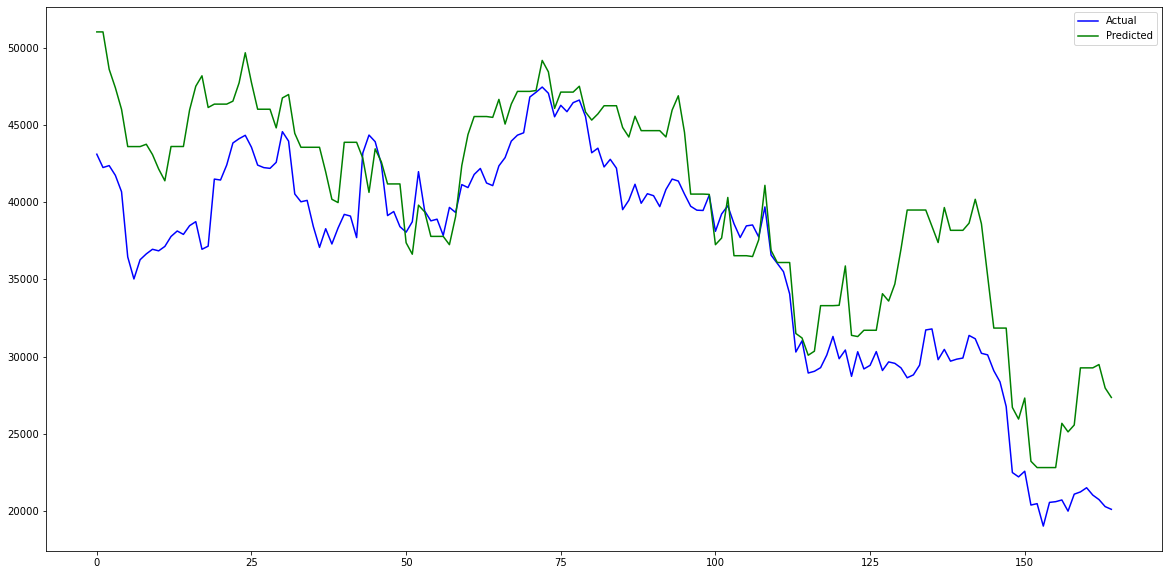

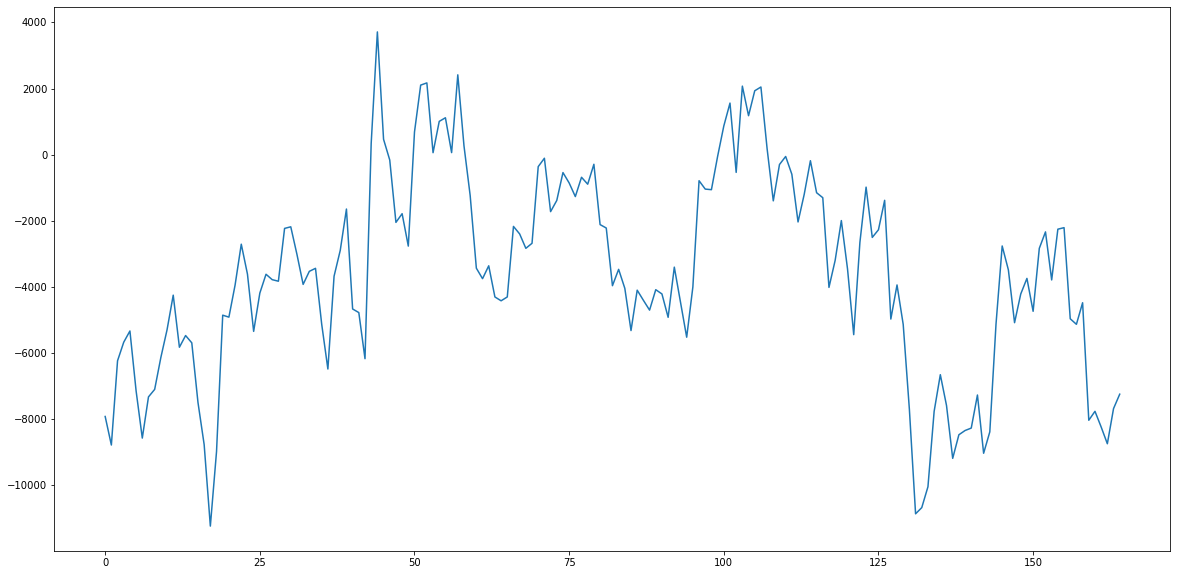

In [107]:
bivariate_regression(nyse_close)

# LSE vs BTC

In [108]:
LSE=get_data("LSEG.L")

[*********************100%***********************]  1 of 1 completed


In [109]:
LSE_close=LSE["Close"]

The correlation matrix
          Close       BTC
Close  1.000000  0.478678
BTC    0.478678  1.000000
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.212
Model:                            OLS   Adj. R-squared:                  0.211
Method:                 Least Squares   F-statistic:                     396.4
Date:                Thu, 04 Aug 2022   Prob (F-statistic):           2.59e-78
Time:                        20:53:08   Log-Likelihood:                -16379.
No. Observations:                1477   AIC:                         3.276e+04
Df Residuals:                    1475   BIC:                         3.277e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------

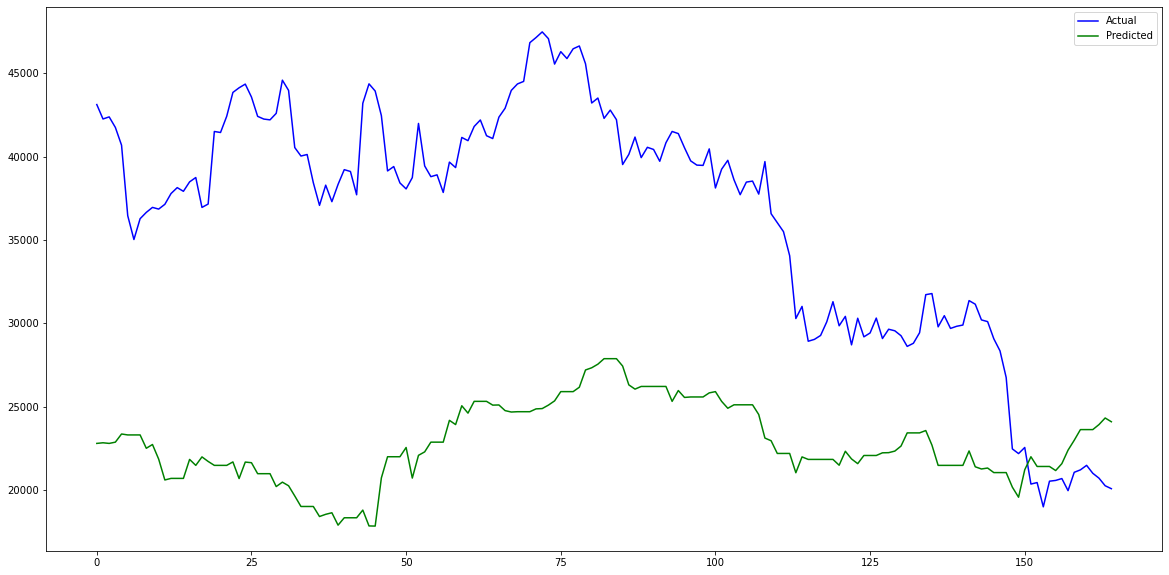

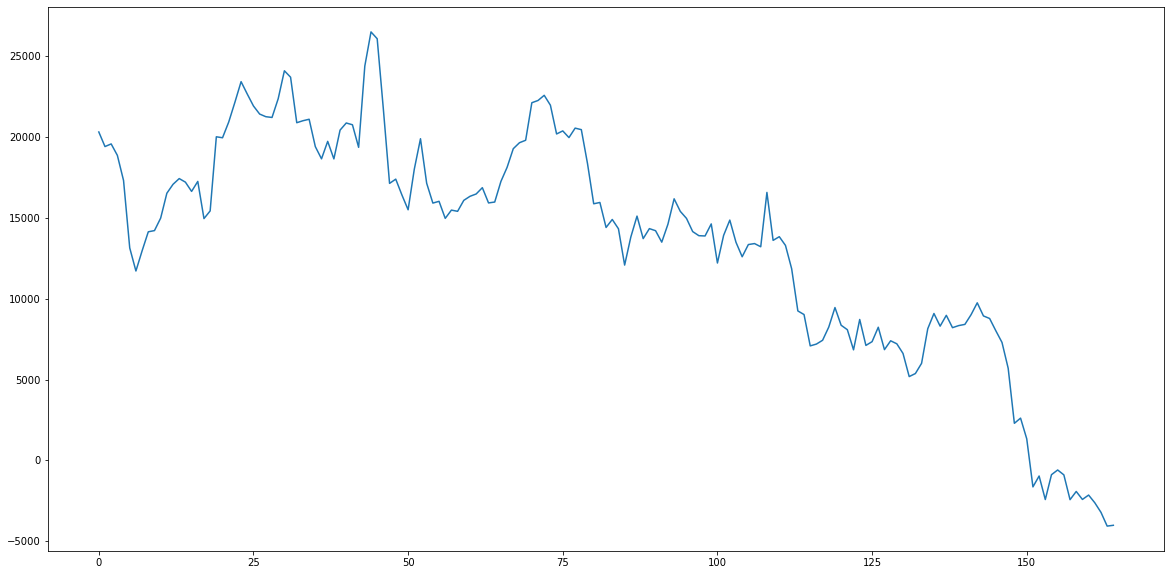

In [110]:
bivariate_regression(LSE_close)

# Gold vs BTC

In [111]:
gold=get_data("GC=F")

[*********************100%***********************]  1 of 1 completed


In [112]:
gold_close=gold["Close"]

The correlation matrix
          Close       BTC
Close  1.000000  0.651761
BTC    0.651761  1.000000
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.375
Model:                            OLS   Adj. R-squared:                  0.374
Method:                 Least Squares   F-statistic:                     883.7
Date:                Thu, 04 Aug 2022   Prob (F-statistic):          1.45e-152
Time:                        20:53:08   Log-Likelihood:                -16208.
No. Observations:                1477   AIC:                         3.242e+04
Df Residuals:                    1475   BIC:                         3.243e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------

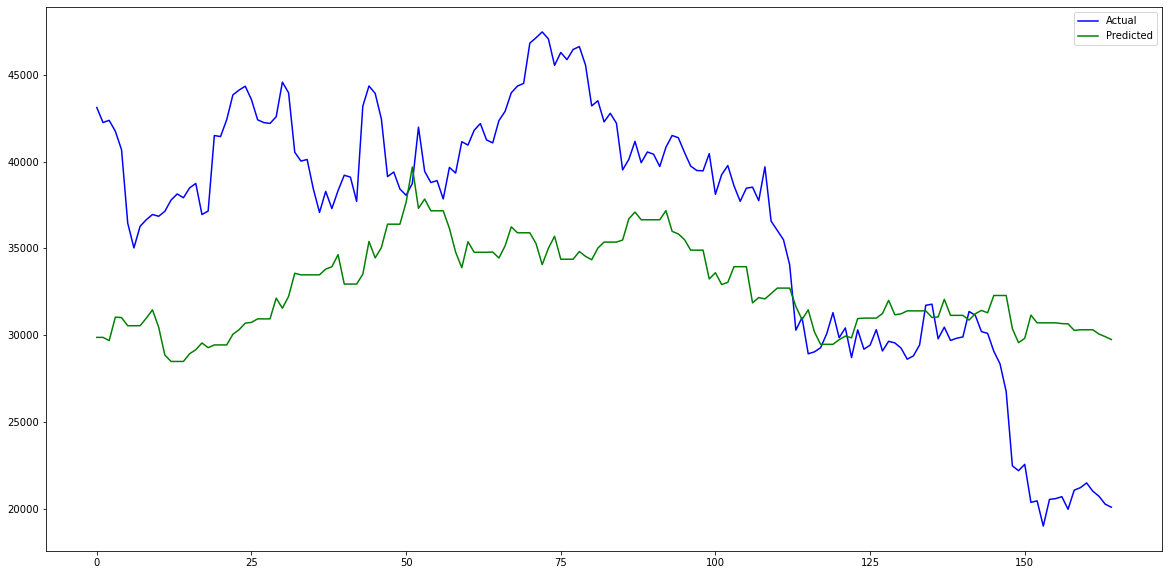

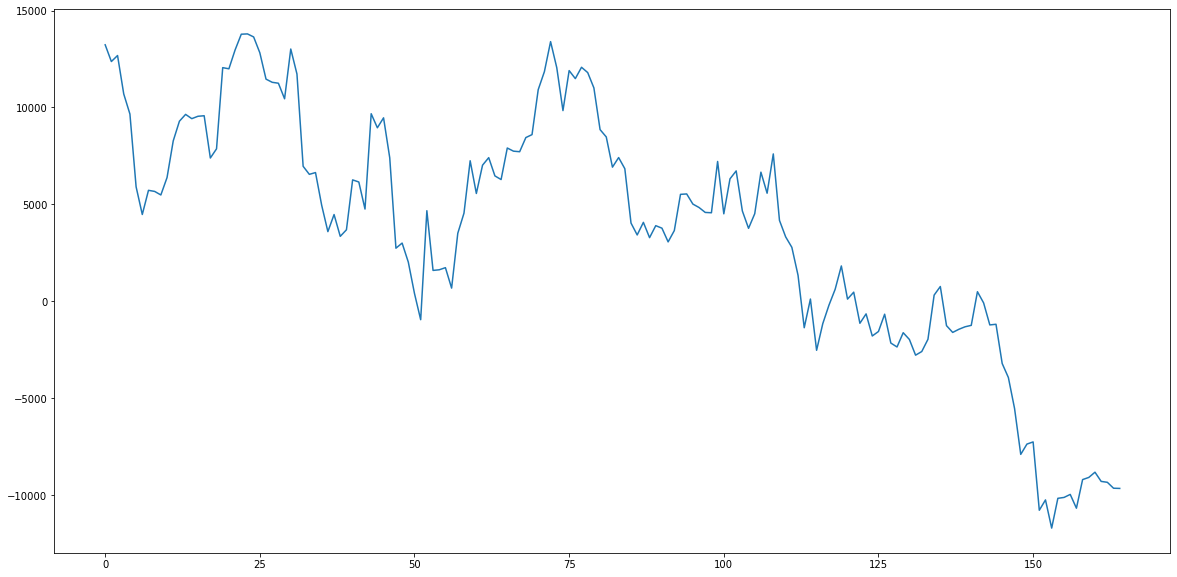

In [113]:
bivariate_regression(gold_close)

# Crude oil vs btc

In [114]:
crude_oil=get_data("CL=F")

[*********************100%***********************]  1 of 1 completed


In [115]:
crude_oil_close=crude_oil["Close"]

The correlation matrix
          Close       BTC
Close  1.000000  0.479567
BTC    0.479567  1.000000
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.188
Model:                            OLS   Adj. R-squared:                  0.187
Method:                 Least Squares   F-statistic:                     340.8
Date:                Thu, 04 Aug 2022   Prob (F-statistic):           1.28e-68
Time:                        20:53:09   Log-Likelihood:                -16401.
No. Observations:                1477   AIC:                         3.281e+04
Df Residuals:                    1475   BIC:                         3.282e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------

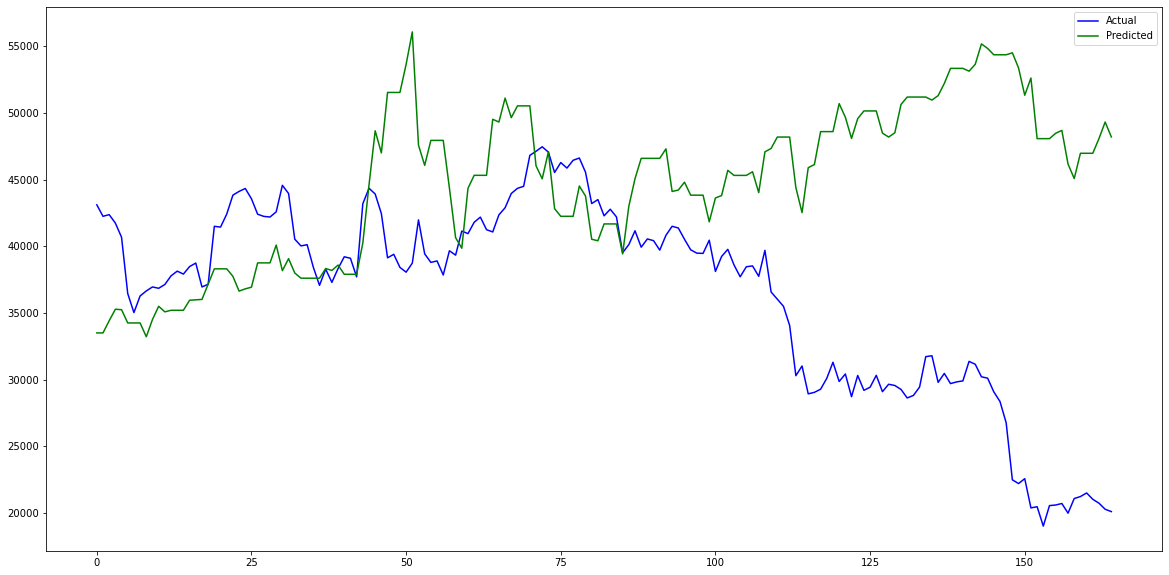

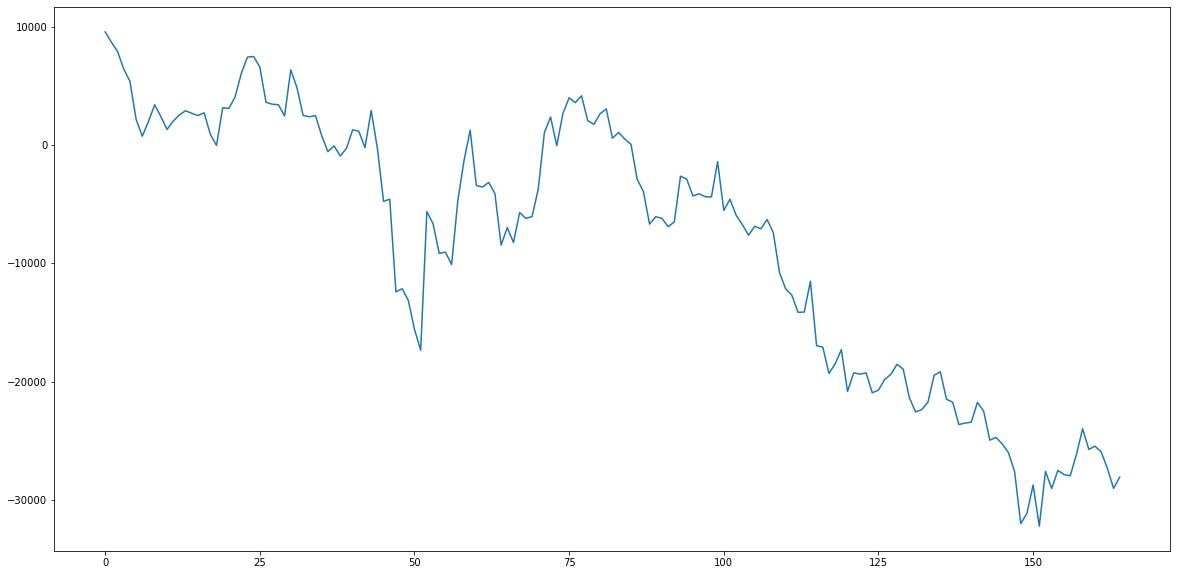

In [116]:
bivariate_regression(crude_oil_close)

# Dow Jones vs BTC

In [117]:
dj=get_data("^DJI")

[*********************100%***********************]  1 of 1 completed


In [118]:
dj_close=dj["Close"]

The correlation matrix
         Close      BTC
Close  1.00000  0.90642
BTC    0.90642  1.00000
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.809
Model:                            OLS   Adj. R-squared:                  0.808
Method:                 Least Squares   F-statistic:                     6231.
Date:                Thu, 04 Aug 2022   Prob (F-statistic):               0.00
Time:                        20:53:10   Log-Likelihood:                -15334.
No. Observations:                1477   AIC:                         3.067e+04
Df Residuals:                    1475   BIC:                         3.068e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------

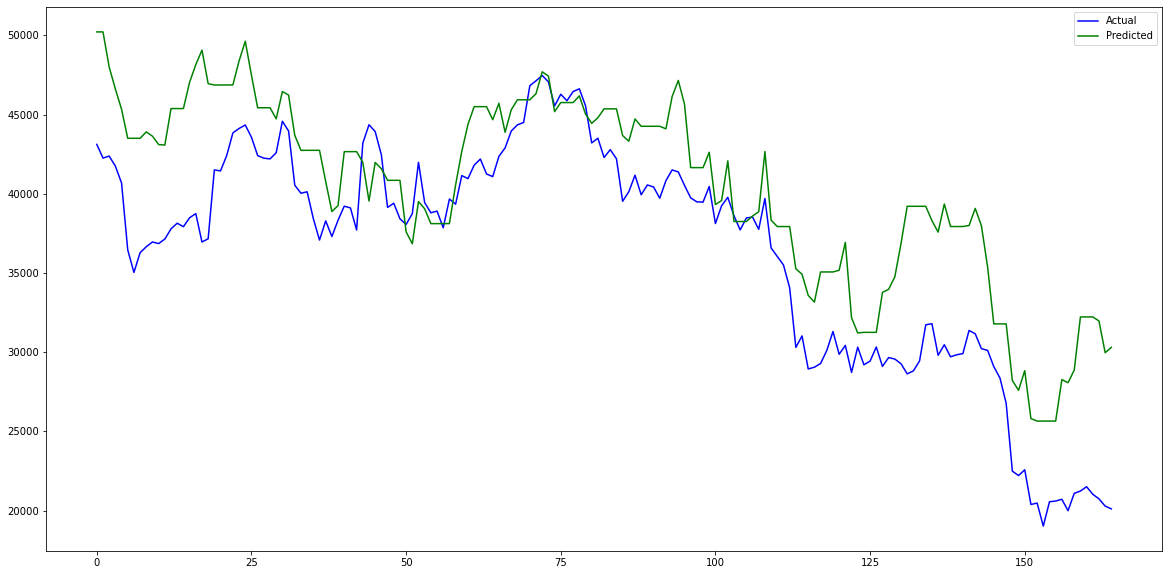

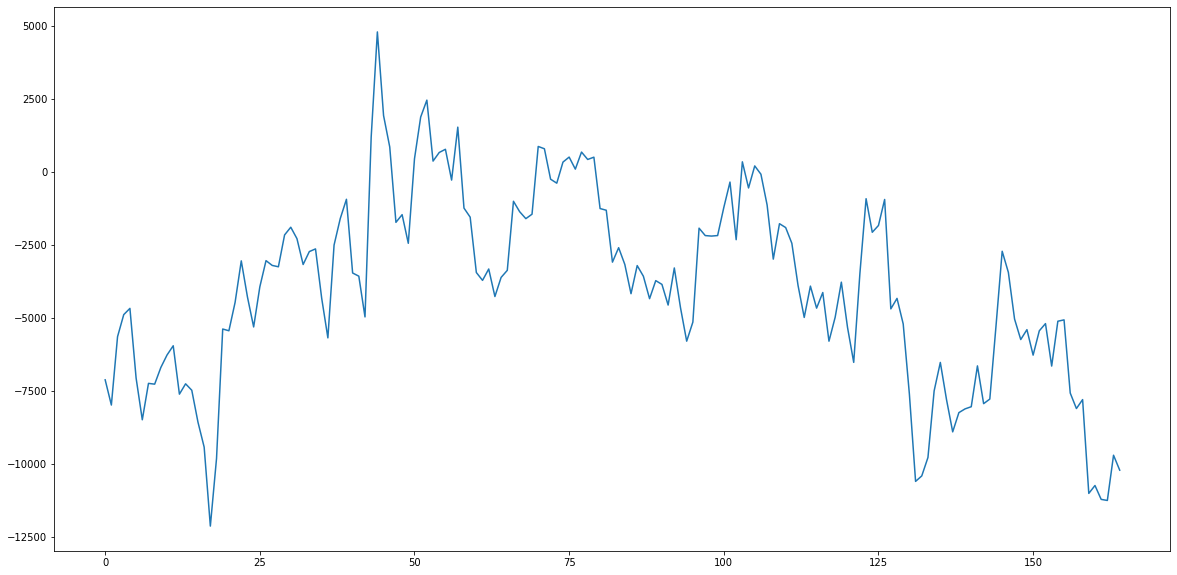

In [119]:
bivariate_regression(dj_close)

# NASDAQ vs BTC

In [120]:
nasdaq=get_data("^IXIC")

[*********************100%***********************]  1 of 1 completed


In [121]:
nasdaq_close=nasdaq["Close"]

The correlation matrix
          Close       BTC
Close  1.000000  0.910349
BTC    0.910349  1.000000
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.813
Model:                            OLS   Adj. R-squared:                  0.813
Method:                 Least Squares   F-statistic:                     6398.
Date:                Thu, 04 Aug 2022   Prob (F-statistic):               0.00
Time:                        20:53:11   Log-Likelihood:                -15318.
No. Observations:                1477   AIC:                         3.064e+04
Df Residuals:                    1475   BIC:                         3.065e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------

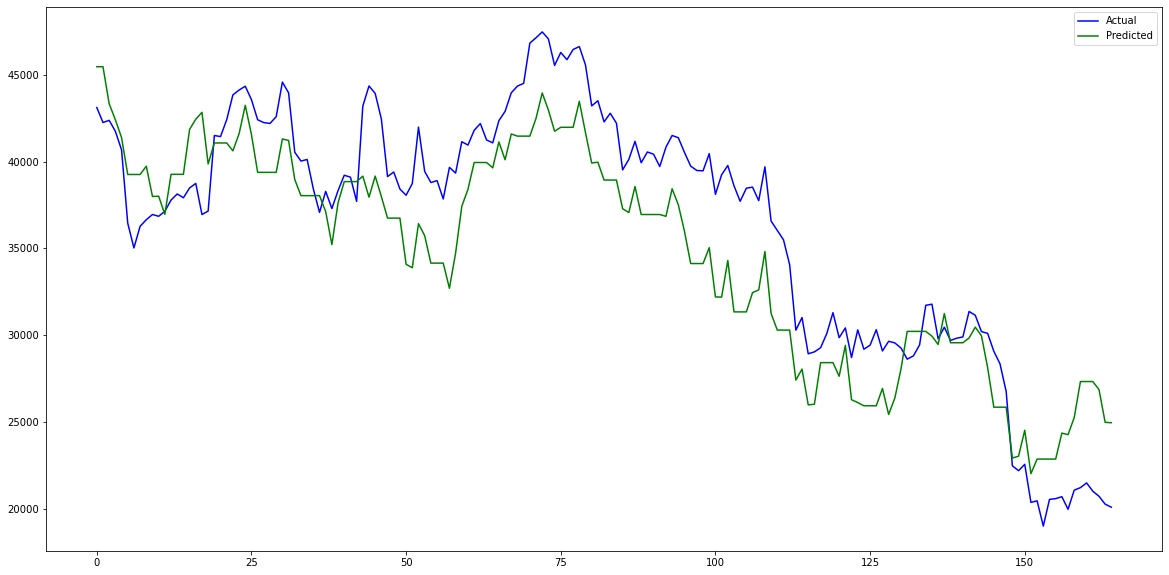

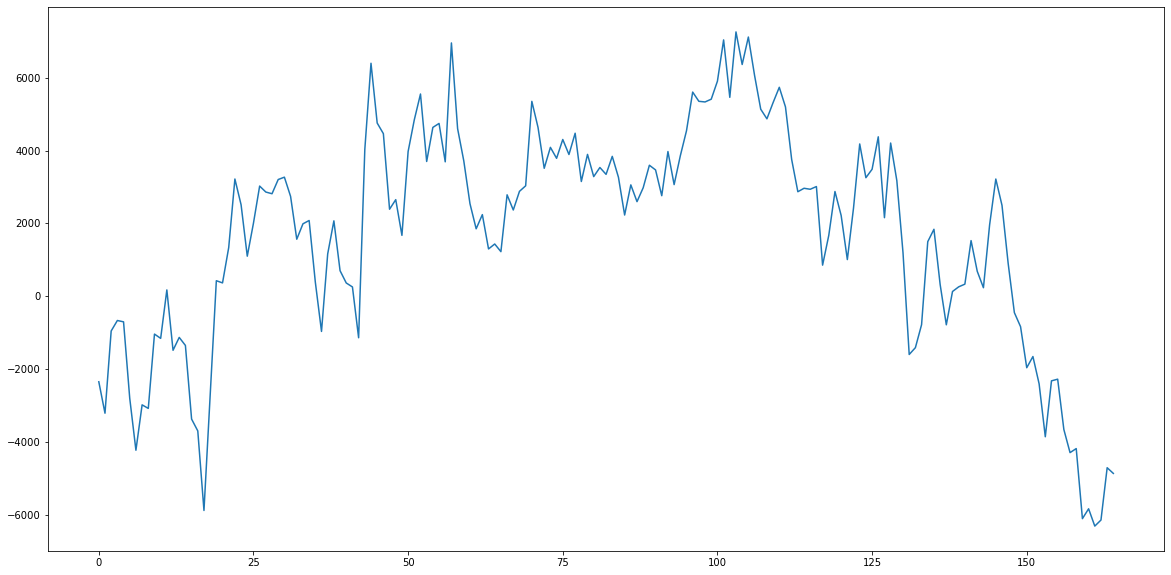

In [122]:
bivariate_regression(nasdaq_close)

# 10 year Treasury Yield vs BTC

In [123]:
t_yield=get_data("^TNX")

[*********************100%***********************]  1 of 1 completed


In [124]:
t_yield_close=t_yield["Close"]

The correlation matrix
          Close       BTC
Close  1.000000 -0.249418
BTC   -0.249418  1.000000
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.115
Model:                            OLS   Adj. R-squared:                  0.115
Method:                 Least Squares   F-statistic:                     192.4
Date:                Thu, 04 Aug 2022   Prob (F-statistic):           3.20e-41
Time:                        20:53:12   Log-Likelihood:                -16464.
No. Observations:                1477   AIC:                         3.293e+04
Df Residuals:                    1475   BIC:                         3.294e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------

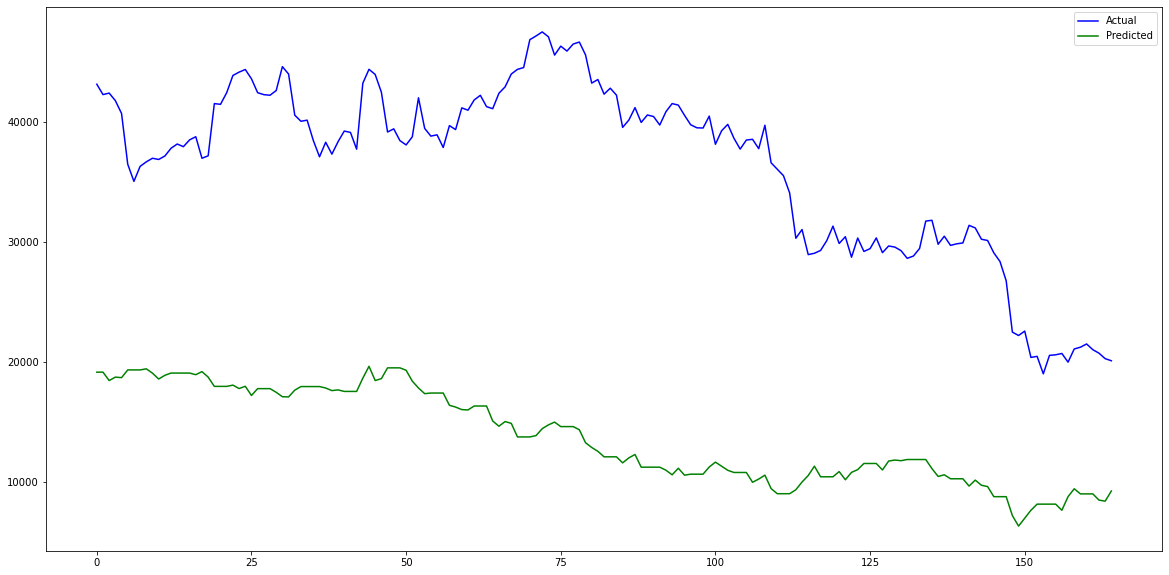

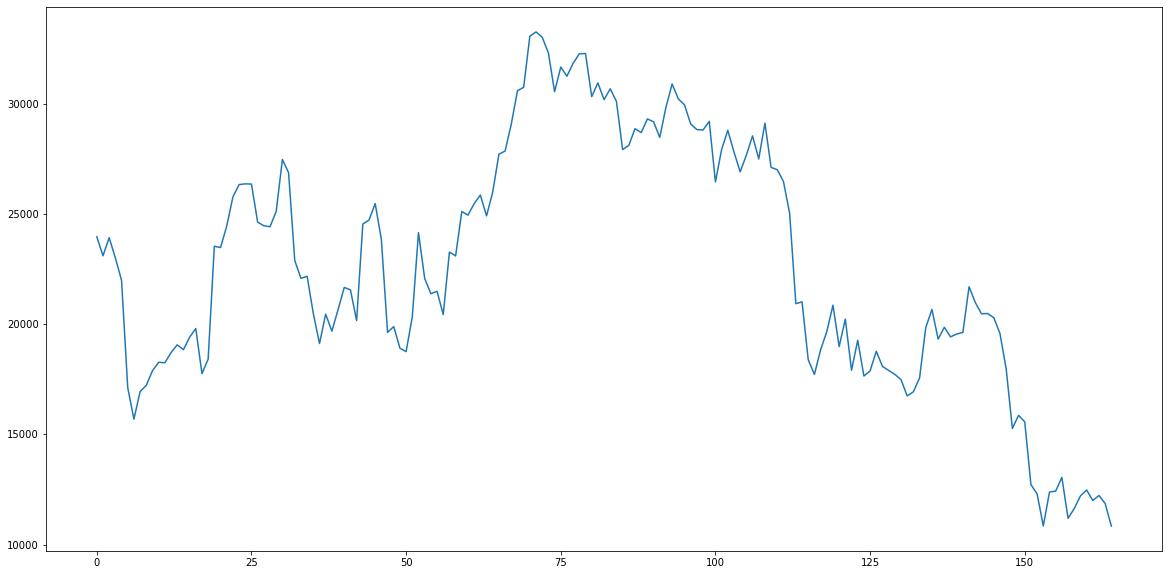

In [125]:
bivariate_regression(t_yield_close)

# NASDAQ100TECH vs BTC

In [126]:
nasdaqtech=get_data("^NDXT")

[*********************100%***********************]  1 of 1 completed


In [127]:
nasdaqtech_close=nasdaqtech["Close"]

The correlation matrix
          Close       BTC
Close  1.000000  0.908548
BTC    0.908548  1.000000
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.812
Model:                            OLS   Adj. R-squared:                  0.812
Method:                 Least Squares   F-statistic:                     6364.
Date:                Thu, 04 Aug 2022   Prob (F-statistic):               0.00
Time:                        20:53:13   Log-Likelihood:                -15321.
No. Observations:                1477   AIC:                         3.065e+04
Df Residuals:                    1475   BIC:                         3.066e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------

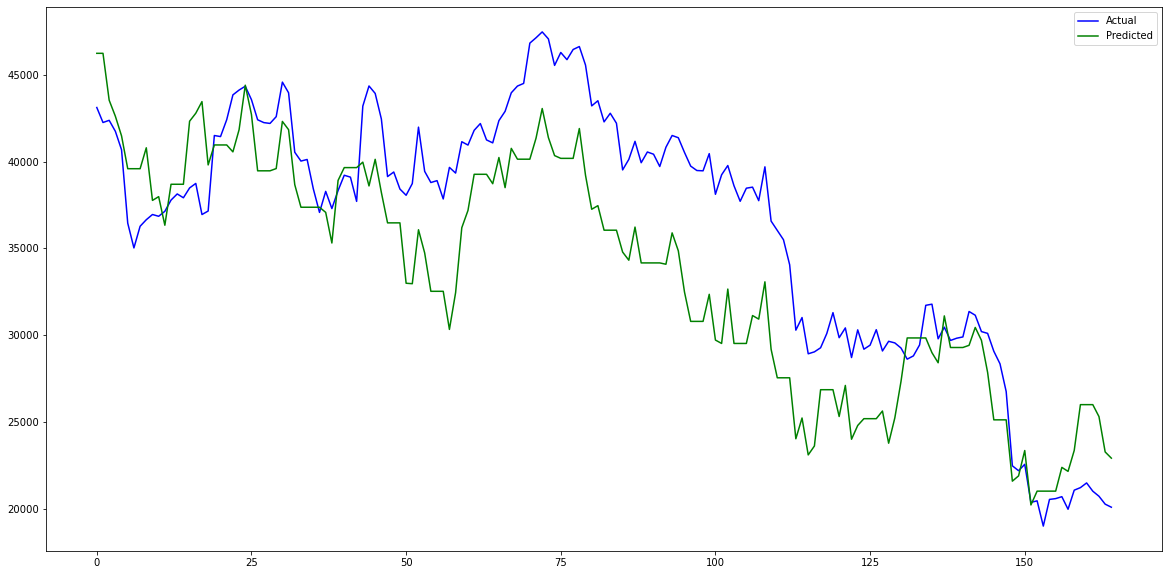

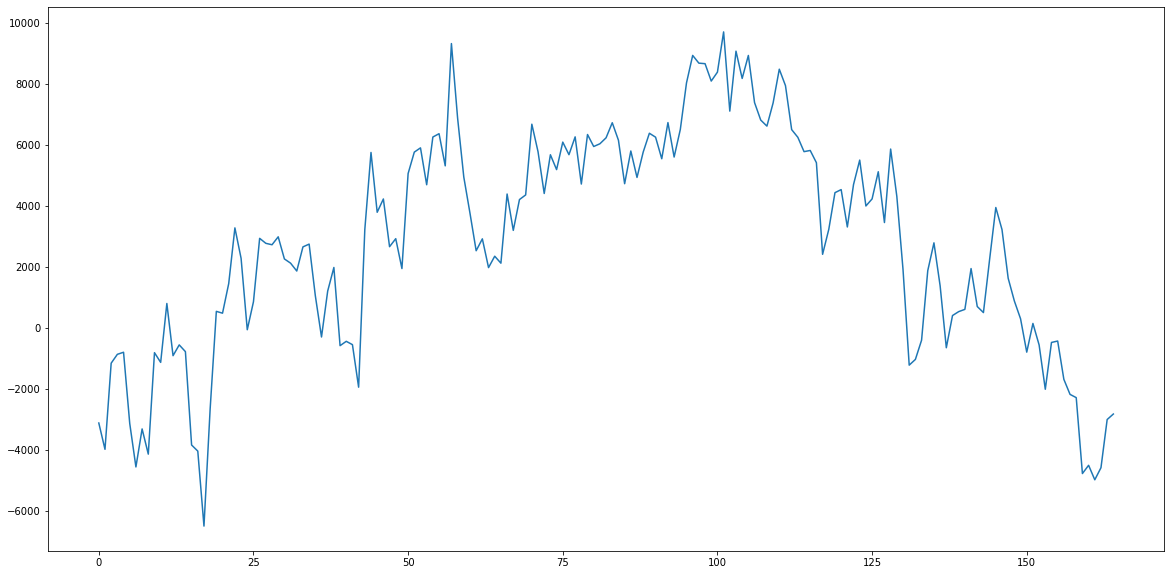

In [128]:
bivariate_regression(nasdaqtech_close)

# NASDAQBANK vs BTC

In [129]:
nasdaq_bank=get_data("^BANK")

[*********************100%***********************]  1 of 1 completed


In [130]:
nasdaq_bank_close=nasdaq_bank["Close"]

The correlation matrix
          Close       BTC
Close  1.000000  0.674536
BTC    0.674536  1.000000
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.406
Model:                            OLS   Adj. R-squared:                  0.406
Method:                 Least Squares   F-statistic:                     1009.
Date:                Thu, 04 Aug 2022   Prob (F-statistic):          3.32e-169
Time:                        20:53:14   Log-Likelihood:                -16170.
No. Observations:                1477   AIC:                         3.234e+04
Df Residuals:                    1475   BIC:                         3.235e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------

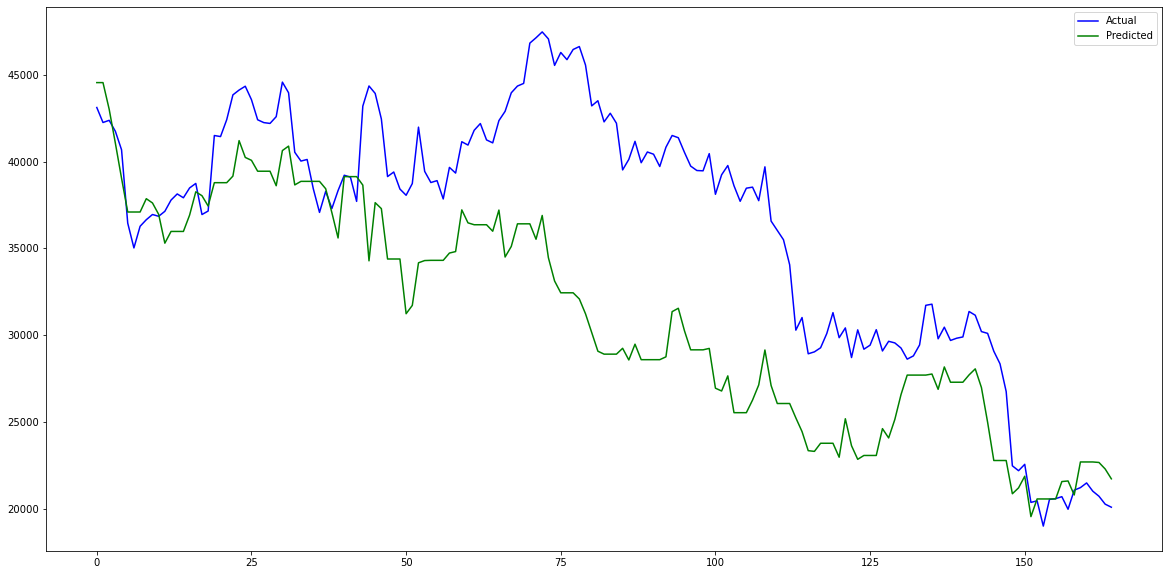

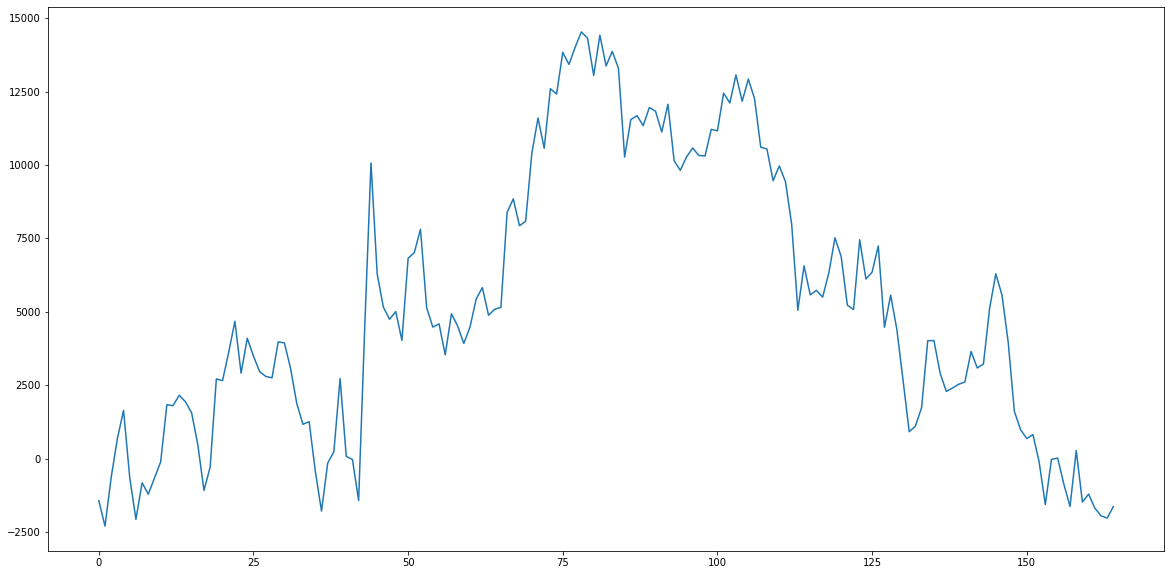

In [131]:
bivariate_regression(nasdaq_bank_close)

# TSLA vs BTC

In [132]:
tsla=get_data("TSLA")

[*********************100%***********************]  1 of 1 completed


In [133]:
tsla_close=tsla["Close"]

The correlation matrix
          Close       BTC
Close  1.000000  0.907354
BTC    0.907354  1.000000
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.833
Model:                            OLS   Adj. R-squared:                  0.833
Method:                 Least Squares   F-statistic:                     7358.
Date:                Thu, 04 Aug 2022   Prob (F-statistic):               0.00
Time:                        20:53:15   Log-Likelihood:                -15233.
No. Observations:                1477   AIC:                         3.047e+04
Df Residuals:                    1475   BIC:                         3.048e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------

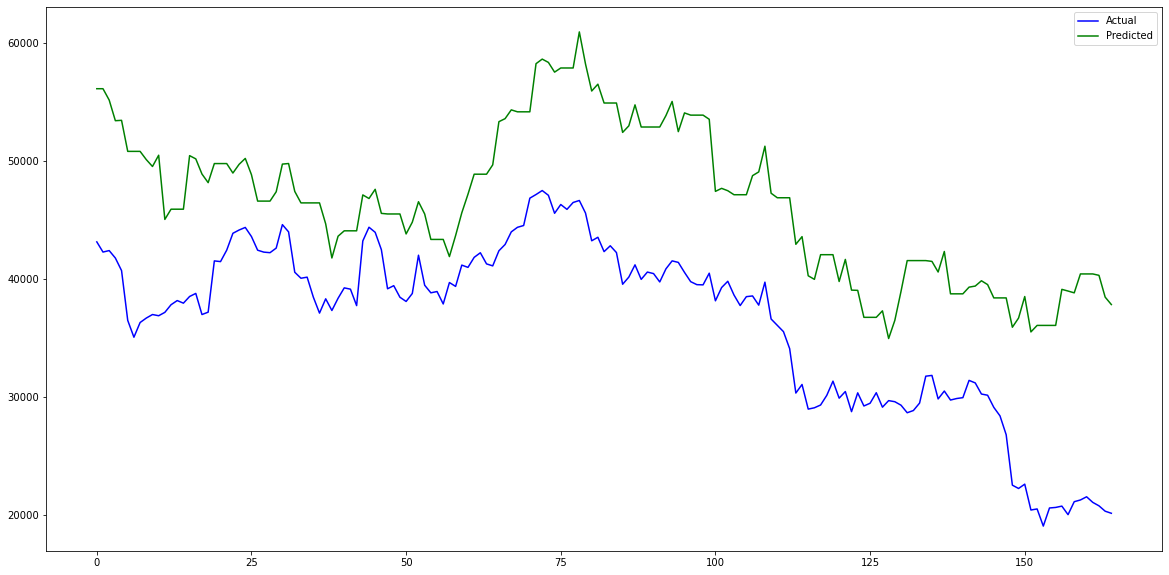

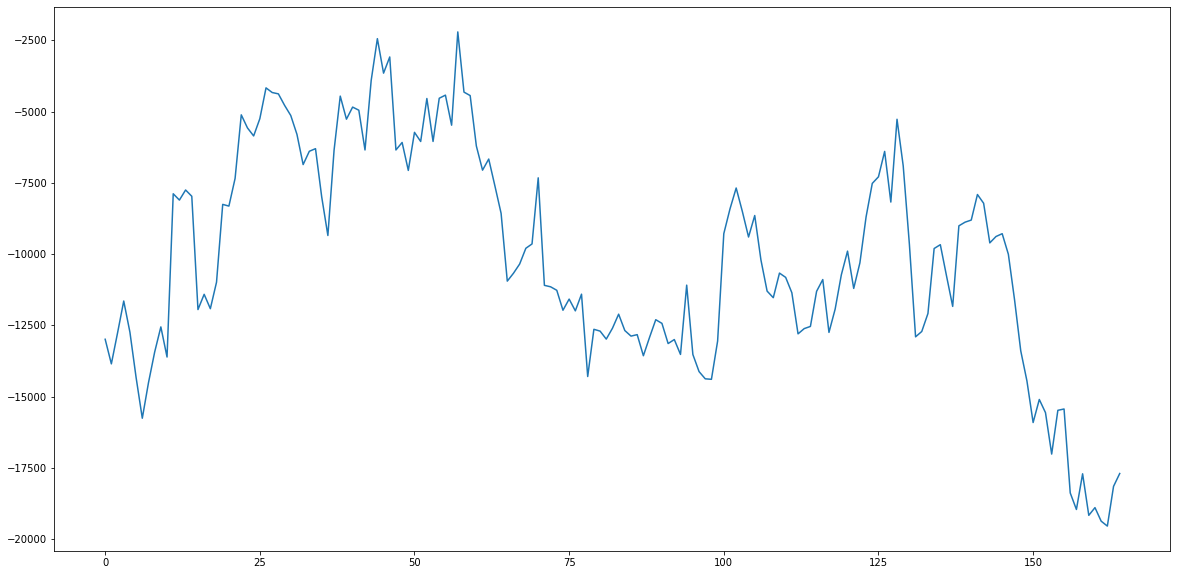

In [134]:
bivariate_regression(tsla_close)

# IQ Real Return ETF (CPI)

In [135]:
cpi=get_data("CPI")

[*********************100%***********************]  1 of 1 completed


In [136]:
cpi_close=cpi["Close"]

The correlation matrix
          Close       BTC
Close  1.000000 -0.134688
BTC   -0.134688  1.000000
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     23.87
Date:                Thu, 04 Aug 2022   Prob (F-statistic):           1.14e-06
Time:                        20:53:15   Log-Likelihood:                -16543.
No. Observations:                1477   AIC:                         3.309e+04
Df Residuals:                    1475   BIC:                         3.310e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------

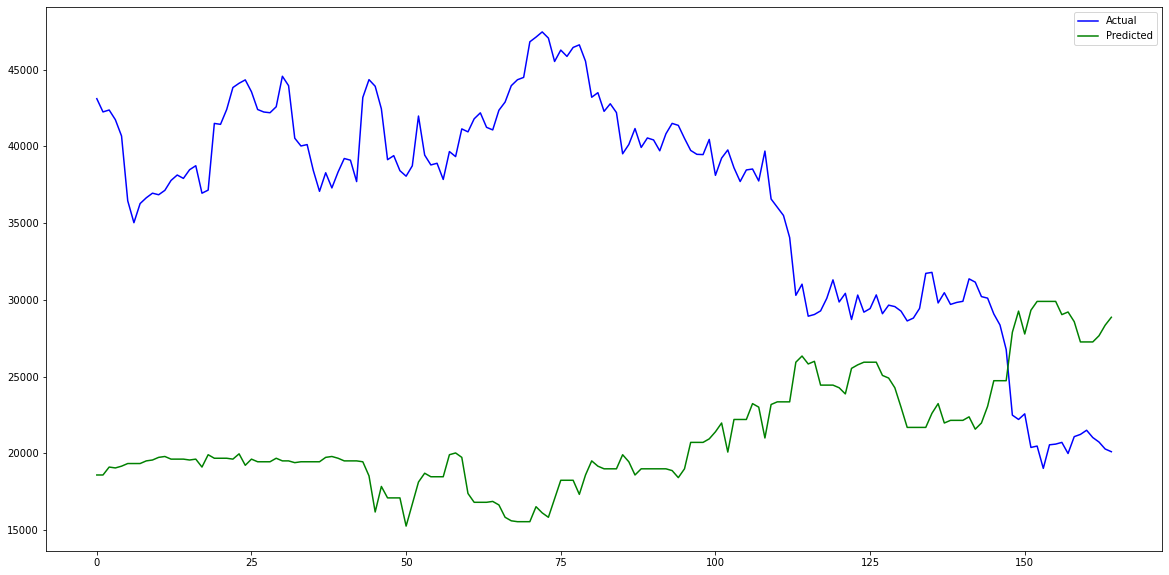

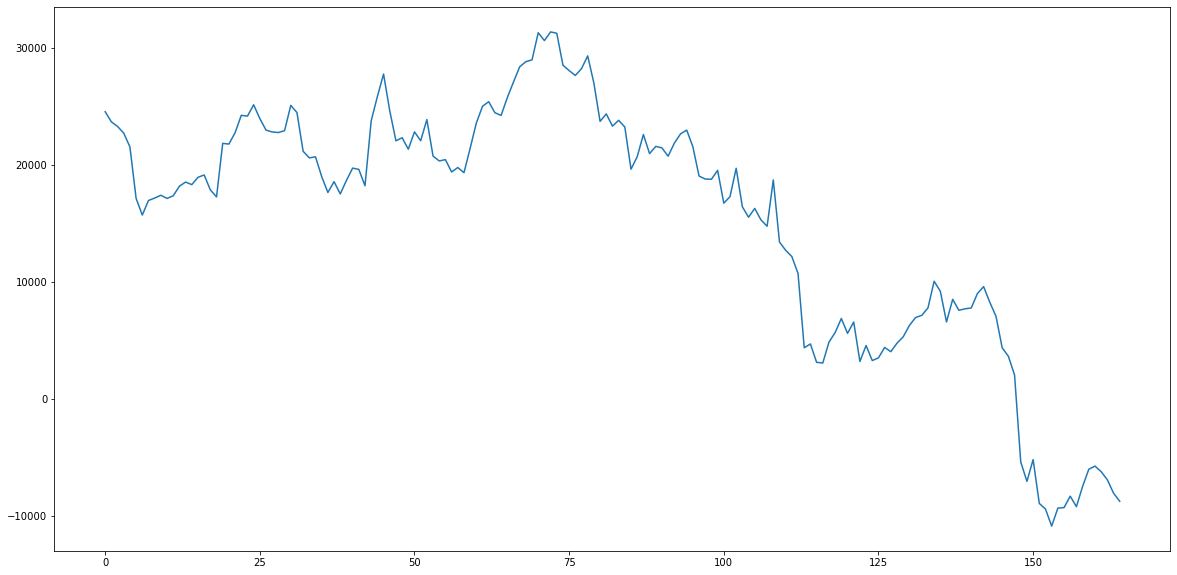

In [137]:
bivariate_regression(cpi_close)

# Index Funds S&P 500 Equal Weight No Load Shares

In [138]:
id=get_data("INDEX")

[*********************100%***********************]  1 of 1 completed


In [139]:
id_close=id["Close"]

The correlation matrix
          Close       BTC
Close  1.000000  0.919506
BTC    0.919506  1.000000
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.846
Model:                            OLS   Adj. R-squared:                  0.846
Method:                 Least Squares   F-statistic:                     8085.
Date:                Thu, 04 Aug 2022   Prob (F-statistic):               0.00
Time:                        20:53:16   Log-Likelihood:                -15174.
No. Observations:                1477   AIC:                         3.035e+04
Df Residuals:                    1475   BIC:                         3.036e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------

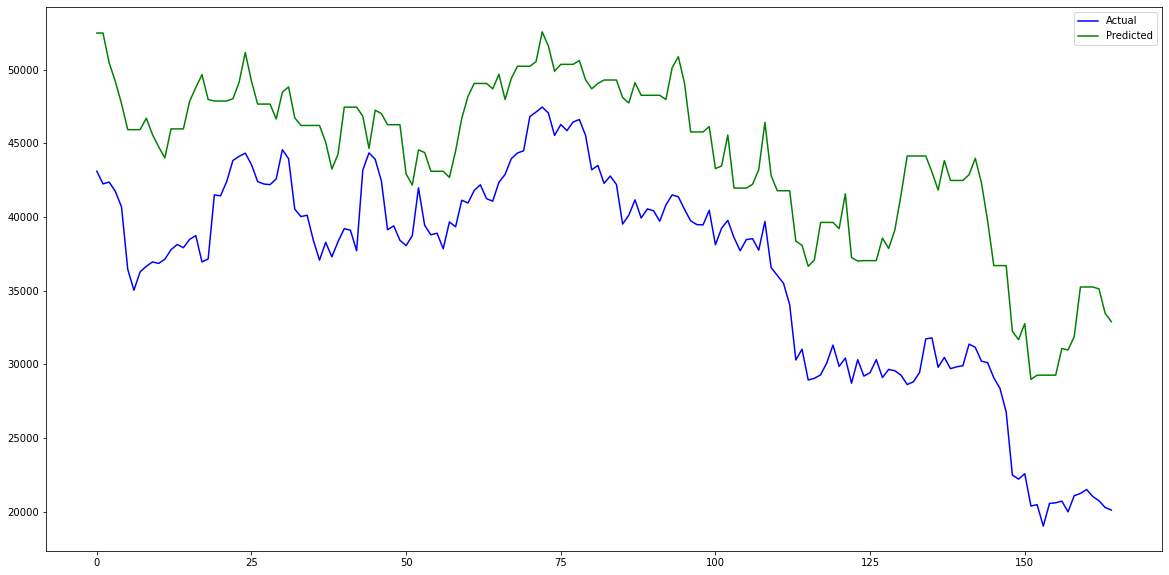

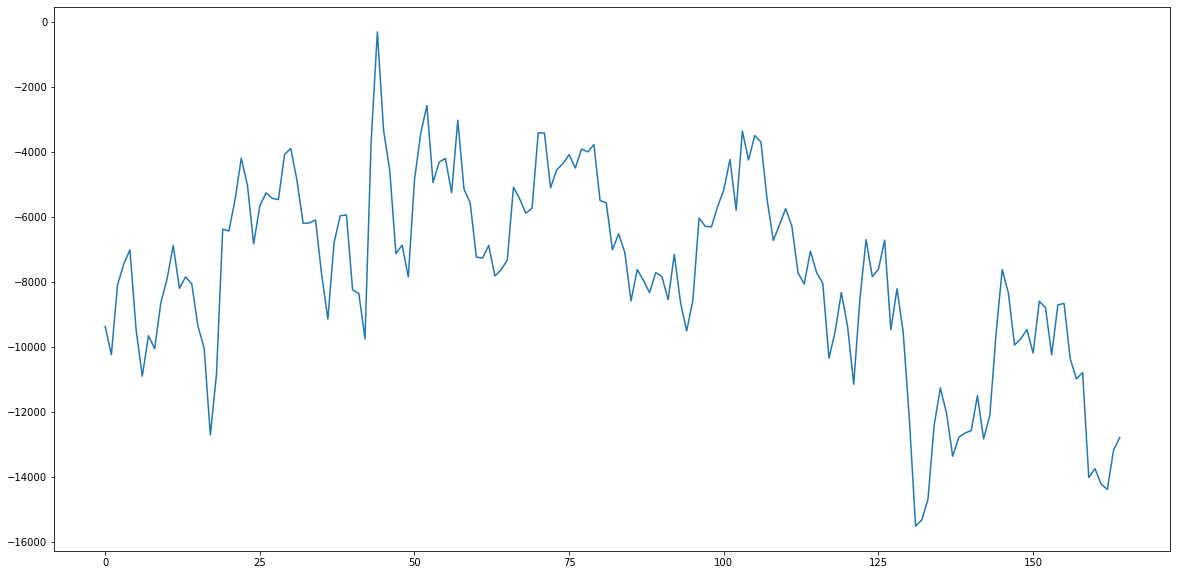

In [140]:
bivariate_regression(id_close)

# Singapore Stock Exchange

In [141]:
SEL=get_data("S68.SI")

[*********************100%***********************]  1 of 1 completed


In [142]:
SEL_close=SEL["Close"]

The correlation matrix
          Close       BTC
Close  1.000000  0.753342
BTC    0.753342  1.000000
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.543
Model:                            OLS   Adj. R-squared:                  0.543
Method:                 Least Squares   F-statistic:                     1753.
Date:                Thu, 04 Aug 2022   Prob (F-statistic):          3.99e-253
Time:                        20:53:17   Log-Likelihood:                -15976.
No. Observations:                1477   AIC:                         3.196e+04
Df Residuals:                    1475   BIC:                         3.197e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------

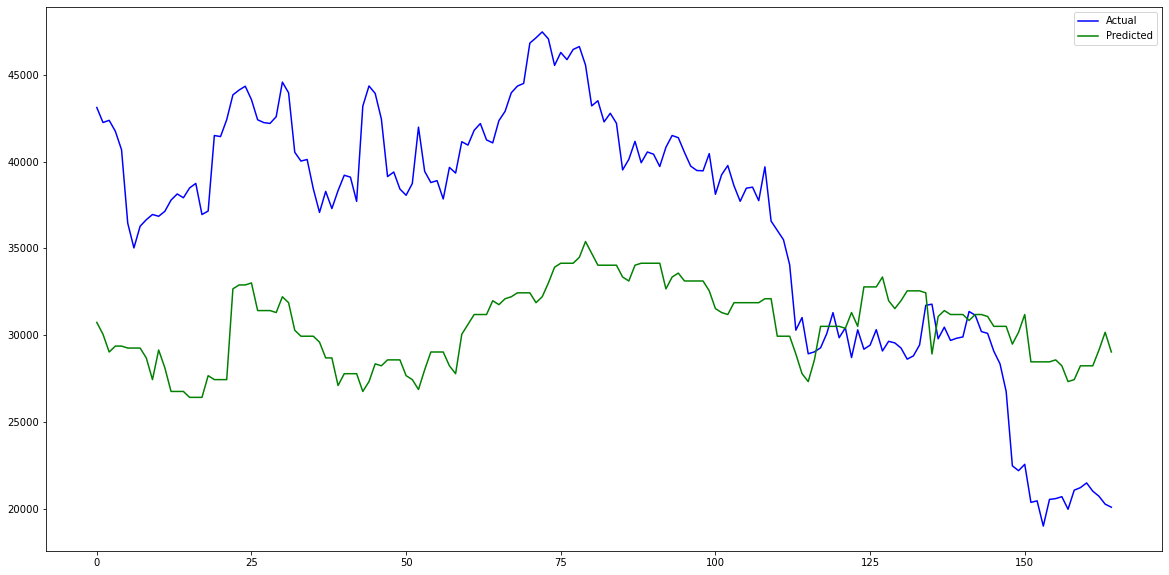

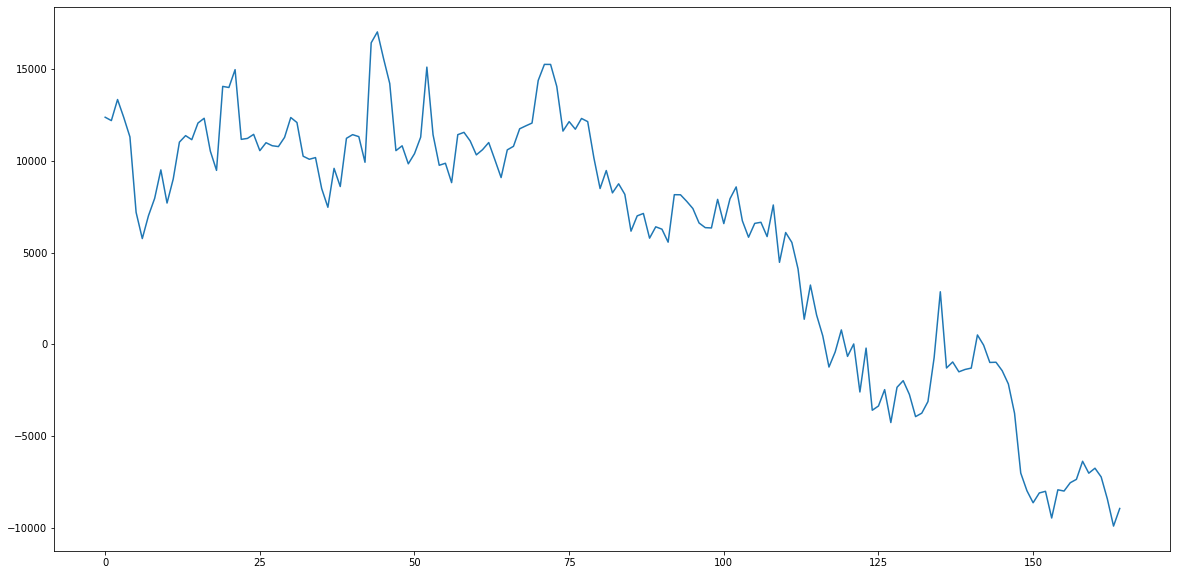

In [143]:
bivariate_regression(SEL_close)

# Strength of US Dollar vs BTC

In [144]:
USDX=get_data('DX-Y.NYB')

[*********************100%***********************]  1 of 1 completed


In [145]:
USDX_close=USDX["Close"]

The correlation matrix
          Close       BTC
Close  1.000000 -0.240645
BTC   -0.240645  1.000000
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.196
Model:                            OLS   Adj. R-squared:                  0.195
Method:                 Least Squares   F-statistic:                     358.8
Date:                Thu, 04 Aug 2022   Prob (F-statistic):           8.61e-72
Time:                        20:53:18   Log-Likelihood:                -16394.
No. Observations:                1477   AIC:                         3.279e+04
Df Residuals:                    1475   BIC:                         3.280e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------

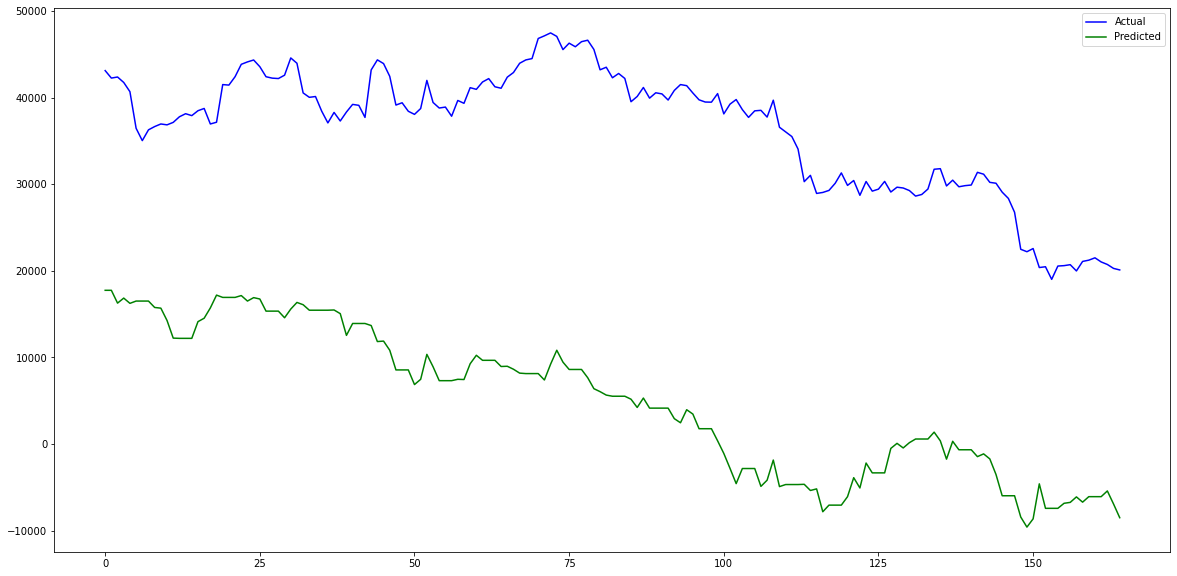

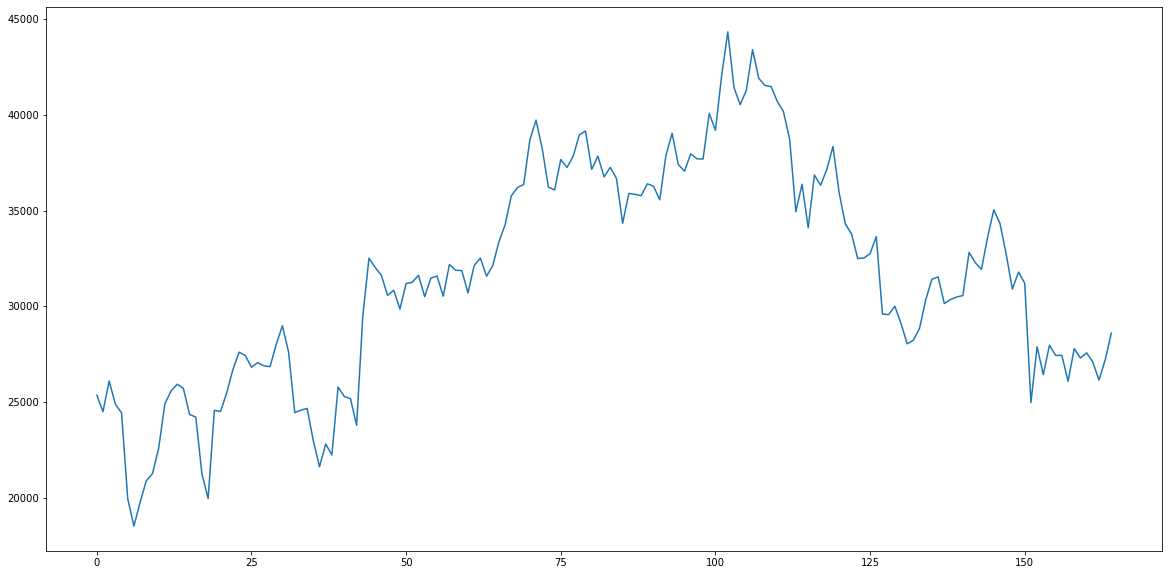

In [146]:
bivariate_regression(USDX_close)

# NIFTY 50

In [147]:
nifty=get_data("^NSEI")

[*********************100%***********************]  1 of 1 completed


In [148]:
nifty_close=nifty["Close"]

The correlation matrix
          Close       BTC
Close  1.000000  0.892771
BTC    0.892771  1.000000
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.813
Model:                            OLS   Adj. R-squared:                  0.813
Method:                 Least Squares   F-statistic:                     6434.
Date:                Thu, 04 Aug 2022   Prob (F-statistic):               0.00
Time:                        20:53:19   Log-Likelihood:                -15314.
No. Observations:                1477   AIC:                         3.063e+04
Df Residuals:                    1475   BIC:                         3.064e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------

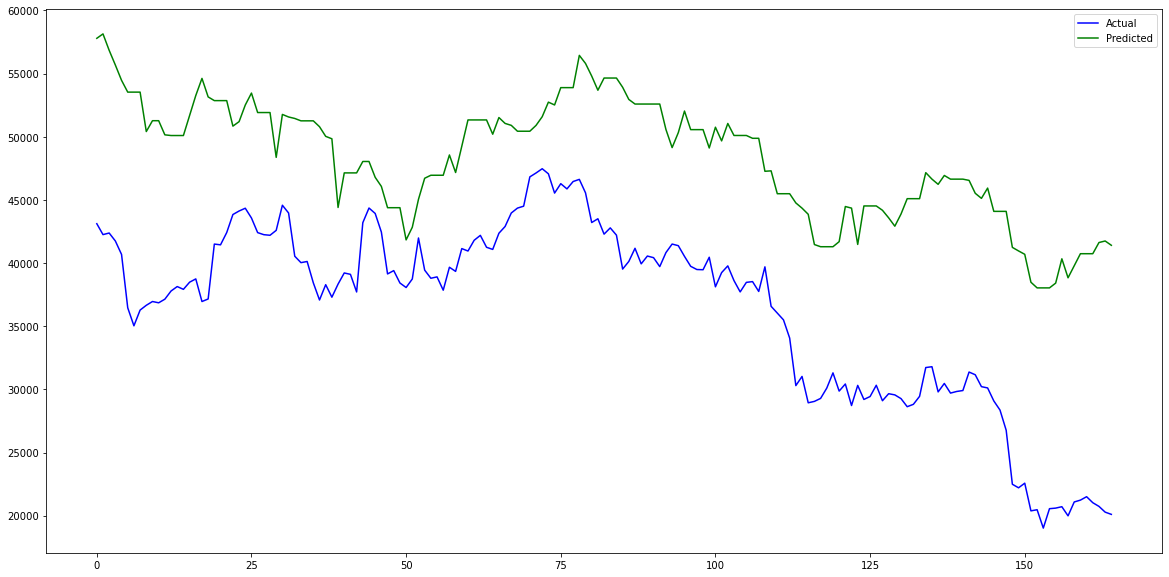

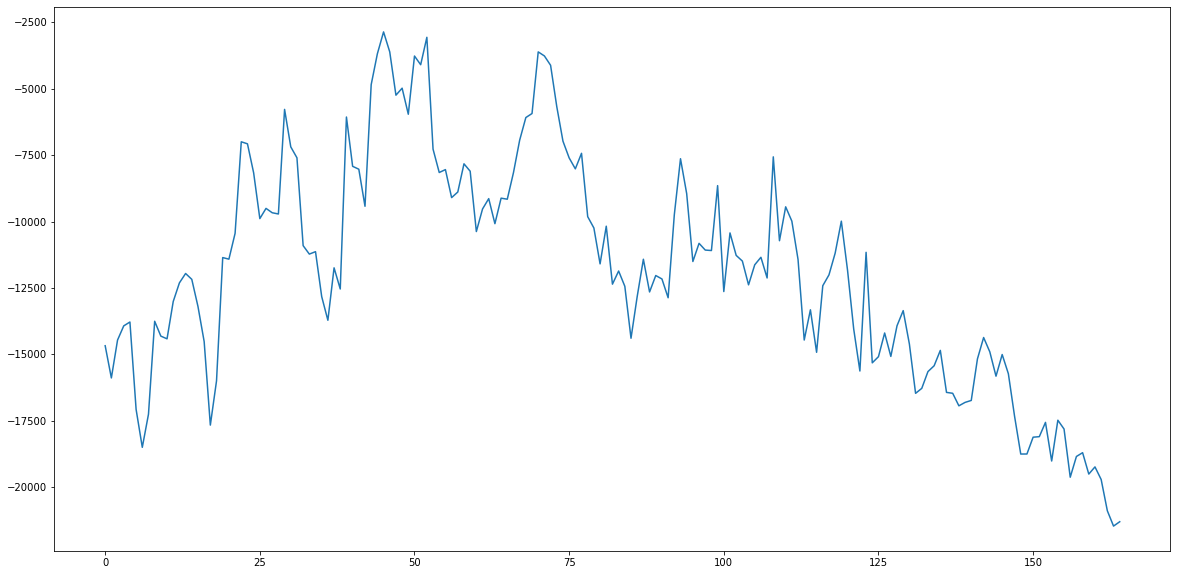

In [149]:
bivariate_regression(nifty_close)

# KC HRW Wheat Futures

In [150]:
wheatKC=get_data("KE=F")

[*********************100%***********************]  1 of 1 completed


In [151]:
wheatKC_close=wheatKC["Close"]

The correlation matrix
          Close       BTC
Close  1.000000  0.662767
BTC    0.662767  1.000000
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.735
Model:                            OLS   Adj. R-squared:                  0.735
Method:                 Least Squares   F-statistic:                     4086.
Date:                Thu, 04 Aug 2022   Prob (F-statistic):               0.00
Time:                        20:53:20   Log-Likelihood:                -15574.
No. Observations:                1477   AIC:                         3.115e+04
Df Residuals:                    1475   BIC:                         3.116e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------

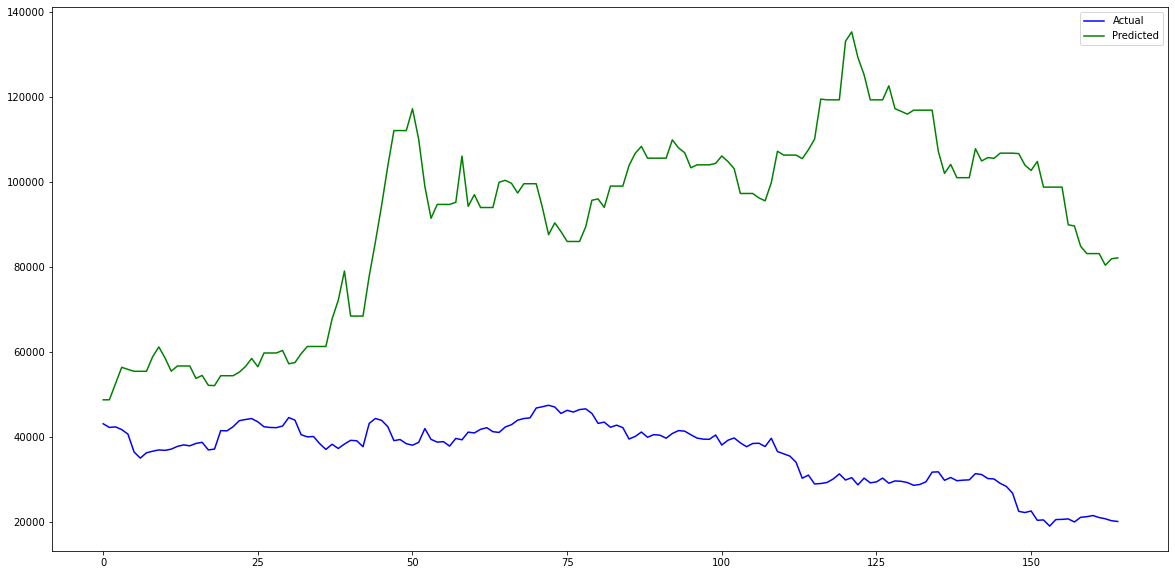

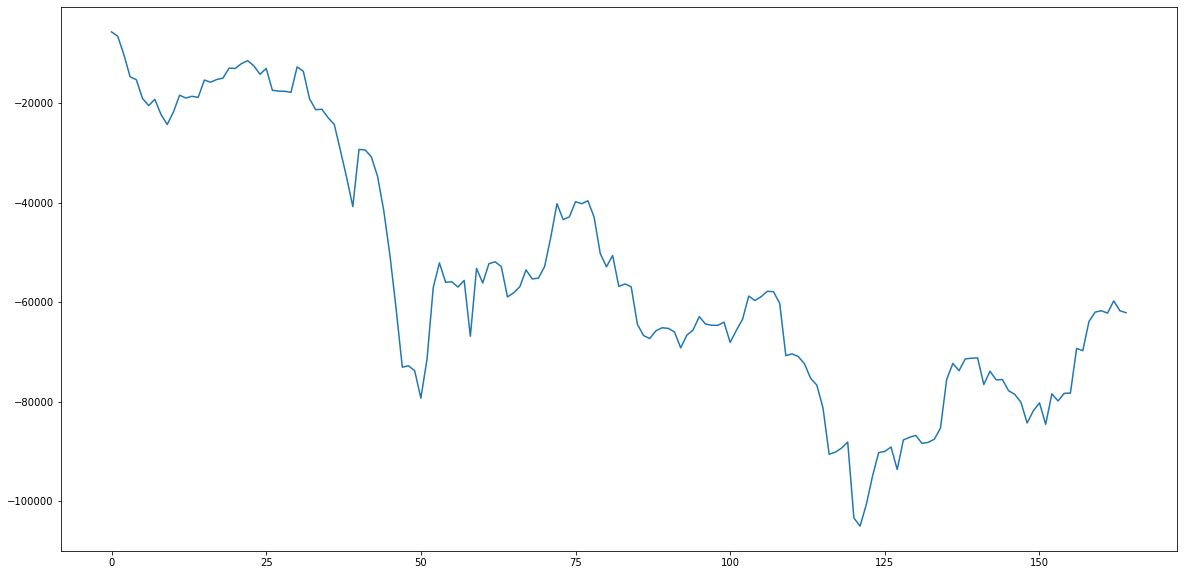

In [152]:
bivariate_regression(wheatKC_close)

# Chicago SRW Wheat Futures

In [153]:
wheatSRW=get_data("ZW=F")

[*********************100%***********************]  1 of 1 completed


In [154]:
wheatSRW_close=wheatSRW["Close"]

The correlation matrix
          Close       BTC
Close  1.000000  0.677662
BTC    0.677662  1.000000
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.776
Model:                            OLS   Adj. R-squared:                  0.776
Method:                 Least Squares   F-statistic:                     5121.
Date:                Thu, 04 Aug 2022   Prob (F-statistic):               0.00
Time:                        20:53:20   Log-Likelihood:                -15448.
No. Observations:                1477   AIC:                         3.090e+04
Df Residuals:                    1475   BIC:                         3.091e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------

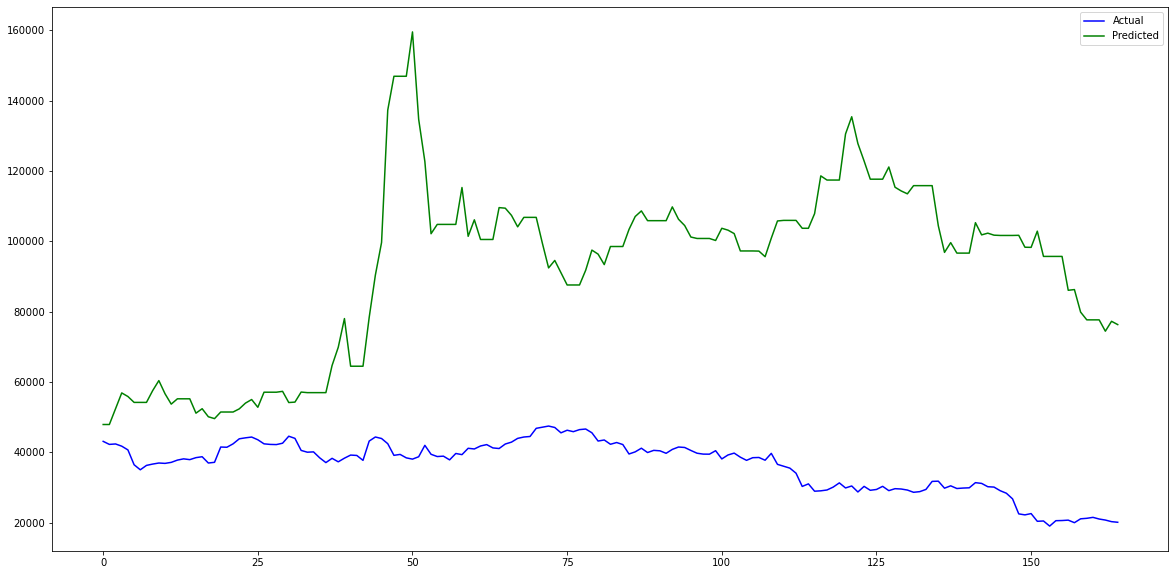

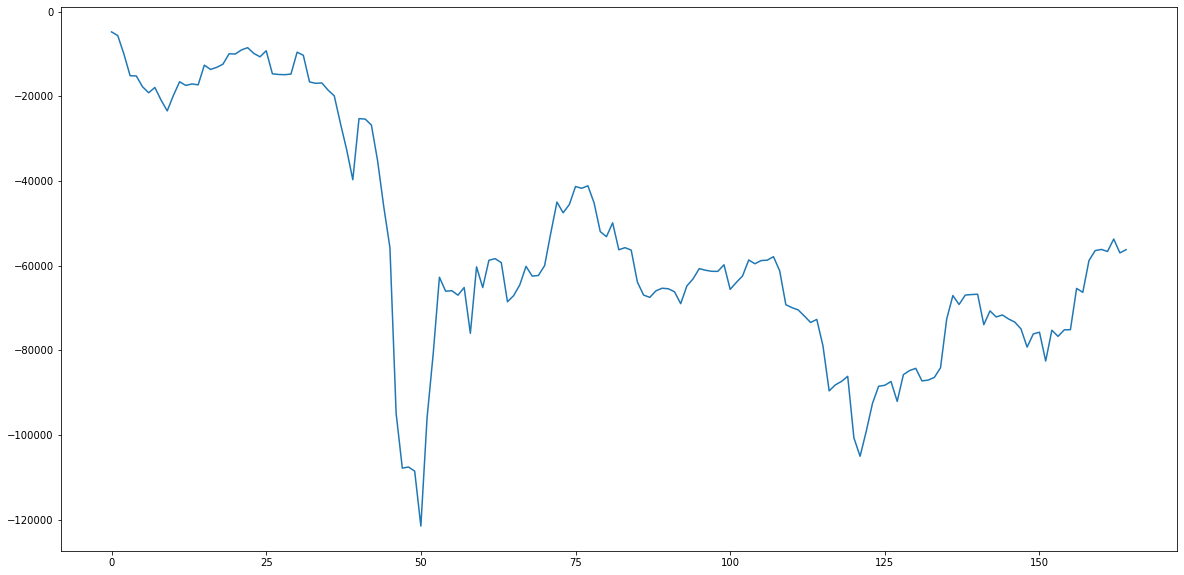

In [155]:
bivariate_regression(wheatSRW_close)

# Summarizing the regression results

In [201]:
results=imread("regression_results.JPG")

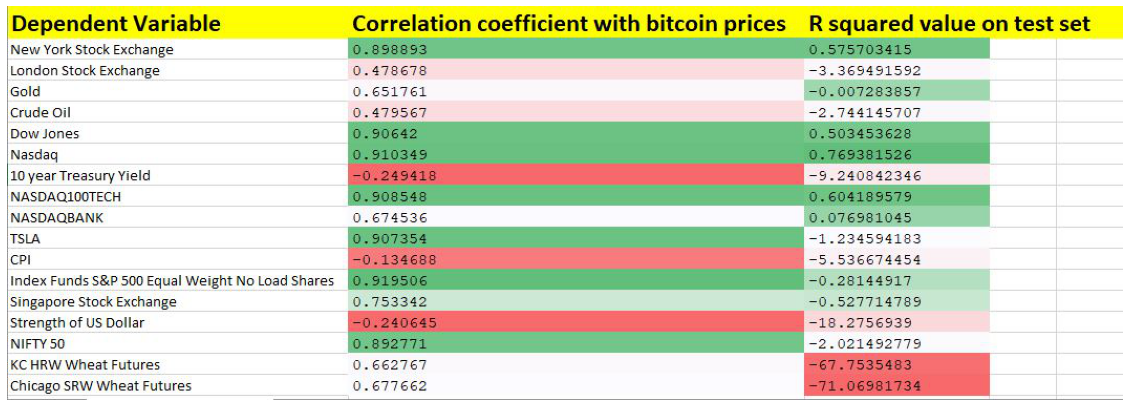

In [202]:
plt.imshow(results)
plt.axis("off")
plt.show()

# Multivariate_regression

In [156]:
df=pd.concat([nyse_close,LSE_close,gold_close,crude_oil_close,dj_close,nasdaq_close,t_yield_close,nasdaqtech_close,
              nasdaq_bank_close,tsla_close,cpi_close,id_close,SEL_close,USDX_close,nifty_close,wheatKC_close,wheatSRW_close,
              btc_close1]
            ,axis=1)
df.columns=["NYSE","LSE","GOLD","CRUDE_OIL","DJ","NASDAQ","TREASURY_BOND","NASDAQTECH","NASDAQBANK","TSLA","CPI","INDEX",
            "SINGAPORE_STOCK_EXCHANGE","USDX","NIFTY 50","WheatKC","WheatSRW","BTC"]

In [157]:
df

NYSE     LSE         GOLD   CRUDE_OIL            DJ  \
Date                                                                      
2017-12-31           NaN     NaN          NaN         NaN           NaN   
2018-01-01           NaN     NaN          NaN         NaN           NaN   
2018-01-02  12902.719727  3742.0  1313.699951   60.369999  24824.009766   
2018-01-03  12957.280273  3749.0  1316.199951   61.630001  24922.679688   
2018-01-04  13028.459961  3749.0  1319.400024   62.009998  25075.130859   
...                  ...     ...          ...         ...           ...   
2022-06-25           NaN     NaN          NaN         NaN           NaN   
2022-06-26           NaN     NaN          NaN         NaN           NaN   
2022-06-27  14835.299805  7664.0  1820.900024  109.570000  31438.259766   
2022-06-28  14667.320312  7748.0  1817.500000  111.760002  30946.990234   
2022-06-29  14599.589844  7700.0  1813.699951  109.779999  31029.310547   

                  NASDAQ  TREASURY_BOND   NASDAQTECH   NASDAQBANK        TSLA  \
Date                                                                            
2017-12-31           NaN            NaN          NaN          NaN         NaN   
2018-01-01           NaN            NaN          NaN          NaN         NaN   
2018-01-02   7006.899902          2.465  3995.959961  3993.090088   64.106003   
2018-01-03   7065.529785          2.447  4044.330078  3991.540039   63.450001   
2018-01-04   7077.910156          2.453  4071.280029  4011.020020   62.924000   
...                  ...            ...          ...          ...         ...   
2022-06-25           NaN            NaN          NaN          NaN         NaN   
2022-06-26           NaN            NaN          NaN          NaN         NaN   
2022-06-27  11524.549805          3.194  6627.799805  4076.090088  734.760010   
2022-06-28  11181.540039          3.206  6398.589844  4053.300049  697.989990   
2022-06-29  11177.889648          3.093  6358.350098  4018.729980  685.469971   

                  CPI      INDEX  SINGAPORE_STOCK_EXCHANGE        USDX  \
Date                                                                     
2017-12-31        NaN        NaN                       NaN         NaN   
2018-01-01        NaN        NaN                       NaN         NaN   
2018-01-02  27.490000  30.600000                      7.47   91.849998   
2018-01-03  27.510000  30.770000                      7.50   92.160004   
2018-01-04  27.459999  30.870001                      7.57   91.849998   
...               ...        ...                       ...         ...   
2022-06-25        NaN        NaN                       NaN         NaN   
2022-06-26        NaN        NaN                       NaN         NaN   
2022-06-27  25.940001  41.459999                      9.55  103.940002   
2022-06-28  25.820000  40.820000                      9.64  104.510002   
2022-06-29  25.730000  40.599998                      9.54  105.110001   

                NIFTY 50  WheatKC  WheatSRW           BTC  
Date                                                       
2017-12-31           NaN      NaN       NaN  14156.400391  
2018-01-01           NaN      NaN       NaN  13657.200195  
2018-01-02  10442.200195   434.75    433.50  14982.099609  
2018-01-03  10443.200195   441.00    436.00  15201.000000  
2018-01-04  10504.799805   439.75    434.00  15599.200195  
...                  ...      ...       ...           ...  
2022-06-25           NaN      NaN       NaN  21502.337891  
2022-06-26           NaN      NaN       NaN  21027.294922  
2022-06-27  15832.049805   972.75    904.00  20735.478516  
2022-06-28  15850.200195   983.75    921.25  20280.634766  
2022-06-29  15799.099609   985.25    915.50  20104.023438  

[1642 rows x 18 columns]

In [158]:
df=df.ffill().bfill()

In [159]:
df

NYSE     LSE         GOLD   CRUDE_OIL            DJ  \
Date                                                                      
2017-12-31  12902.719727  3742.0  1313.699951   60.369999  24824.009766   
2018-01-01  12902.719727  3742.0  1313.699951   60.369999  24824.009766   
2018-01-02  12902.719727  3742.0  1313.699951   60.369999  24824.009766   
2018-01-03  12957.280273  3749.0  1316.199951   61.630001  24922.679688   
2018-01-04  13028.459961  3749.0  1319.400024   62.009998  25075.130859   
...                  ...     ...          ...         ...           ...   
2022-06-25  14811.549805  7600.0  1826.500000  107.620003  31500.679688   
2022-06-26  14811.549805  7600.0  1826.500000  107.620003  31500.679688   
2022-06-27  14835.299805  7664.0  1820.900024  109.570000  31438.259766   
2022-06-28  14667.320312  7748.0  1817.500000  111.760002  30946.990234   
2022-06-29  14599.589844  7700.0  1813.699951  109.779999  31029.310547   

                  NASDAQ  TREASURY_BOND   NASDAQTECH   NASDAQBANK        TSLA  \
Date                                                                            
2017-12-31   7006.899902          2.465  3995.959961  3993.090088   64.106003   
2018-01-01   7006.899902          2.465  3995.959961  3993.090088   64.106003   
2018-01-02   7006.899902          2.465  3995.959961  3993.090088   64.106003   
2018-01-03   7065.529785          2.447  4044.330078  3991.540039   63.450001   
2018-01-04   7077.910156          2.453  4071.280029  4011.020020   62.924000   
...                  ...            ...          ...          ...         ...   
2022-06-25  11607.620117          3.125  6705.290039  4077.879883  737.119995   
2022-06-26  11607.620117          3.125  6705.290039  4077.879883  737.119995   
2022-06-27  11524.549805          3.194  6627.799805  4076.090088  734.760010   
2022-06-28  11181.540039          3.206  6398.589844  4053.300049  697.989990   
2022-06-29  11177.889648          3.093  6358.350098  4018.729980  685.469971   

                  CPI      INDEX  SINGAPORE_STOCK_EXCHANGE        USDX  \
Date                                                                     
2017-12-31  27.490000  30.600000                      7.47   91.849998   
2018-01-01  27.490000  30.600000                      7.47   91.849998   
2018-01-02  27.490000  30.600000                      7.47   91.849998   
2018-01-03  27.510000  30.770000                      7.50   92.160004   
2018-01-04  27.459999  30.870001                      7.57   91.849998   
...               ...        ...                       ...         ...   
2022-06-25  26.010000  41.509998                      9.47  104.190002   
2022-06-26  26.010000  41.509998                      9.47  104.190002   
2022-06-27  25.940001  41.459999                      9.55  103.940002   
2022-06-28  25.820000  40.820000                      9.64  104.510002   
2022-06-29  25.730000  40.599998                      9.54  105.110001   

                NIFTY 50  WheatKC  WheatSRW           BTC  
Date                                                       
2017-12-31  10442.200195   434.75    433.50  14156.400391  
2018-01-01  10442.200195   434.75    433.50  13657.200195  
2018-01-02  10442.200195   434.75    433.50  14982.099609  
2018-01-03  10443.200195   441.00    436.00  15201.000000  
2018-01-04  10504.799805   439.75    434.00  15599.200195  
...                  ...      ...       ...           ...  
2022-06-25  15699.250000   992.50    923.75  21502.337891  
2022-06-26  15699.250000   992.50    923.75  21027.294922  
2022-06-27  15832.049805   972.75    904.00  20735.478516  
2022-06-28  15850.200195   983.75    921.25  20280.634766  
2022-06-29  15799.099609   985.25    915.50  20104.023438  

[1642 rows x 18 columns]

In [160]:
X=df.drop("BTC",axis=1)
X

NYSE     LSE         GOLD   CRUDE_OIL            DJ  \
Date                                                                      
2017-12-31  12902.719727  3742.0  1313.699951   60.369999  24824.009766   
2018-01-01  12902.719727  3742.0  1313.699951   60.369999  24824.009766   
2018-01-02  12902.719727  3742.0  1313.699951   60.369999  24824.009766   
2018-01-03  12957.280273  3749.0  1316.199951   61.630001  24922.679688   
2018-01-04  13028.459961  3749.0  1319.400024   62.009998  25075.130859   
...                  ...     ...          ...         ...           ...   
2022-06-25  14811.549805  7600.0  1826.500000  107.620003  31500.679688   
2022-06-26  14811.549805  7600.0  1826.500000  107.620003  31500.679688   
2022-06-27  14835.299805  7664.0  1820.900024  109.570000  31438.259766   
2022-06-28  14667.320312  7748.0  1817.500000  111.760002  30946.990234   
2022-06-29  14599.589844  7700.0  1813.699951  109.779999  31029.310547   

                  NASDAQ  TREASURY_BOND   NASDAQTECH   NASDAQBANK        TSLA  \
Date                                                                            
2017-12-31   7006.899902          2.465  3995.959961  3993.090088   64.106003   
2018-01-01   7006.899902          2.465  3995.959961  3993.090088   64.106003   
2018-01-02   7006.899902          2.465  3995.959961  3993.090088   64.106003   
2018-01-03   7065.529785          2.447  4044.330078  3991.540039   63.450001   
2018-01-04   7077.910156          2.453  4071.280029  4011.020020   62.924000   
...                  ...            ...          ...          ...         ...   
2022-06-25  11607.620117          3.125  6705.290039  4077.879883  737.119995   
2022-06-26  11607.620117          3.125  6705.290039  4077.879883  737.119995   
2022-06-27  11524.549805          3.194  6627.799805  4076.090088  734.760010   
2022-06-28  11181.540039          3.206  6398.589844  4053.300049  697.989990   
2022-06-29  11177.889648          3.093  6358.350098  4018.729980  685.469971   

                  CPI      INDEX  SINGAPORE_STOCK_EXCHANGE        USDX  \
Date                                                                     
2017-12-31  27.490000  30.600000                      7.47   91.849998   
2018-01-01  27.490000  30.600000                      7.47   91.849998   
2018-01-02  27.490000  30.600000                      7.47   91.849998   
2018-01-03  27.510000  30.770000                      7.50   92.160004   
2018-01-04  27.459999  30.870001                      7.57   91.849998   
...               ...        ...                       ...         ...   
2022-06-25  26.010000  41.509998                      9.47  104.190002   
2022-06-26  26.010000  41.509998                      9.47  104.190002   
2022-06-27  25.940001  41.459999                      9.55  103.940002   
2022-06-28  25.820000  40.820000                      9.64  104.510002   
2022-06-29  25.730000  40.599998                      9.54  105.110001   

                NIFTY 50  WheatKC  WheatSRW  
Date                                         
2017-12-31  10442.200195   434.75    433.50  
2018-01-01  10442.200195   434.75    433.50  
2018-01-02  10442.200195   434.75    433.50  
2018-01-03  10443.200195   441.00    436.00  
2018-01-04  10504.799805   439.75    434.00  
...                  ...      ...       ...  
2022-06-25  15699.250000   992.50    923.75  
2022-06-26  15699.250000   992.50    923.75  
2022-06-27  15832.049805   972.75    904.00  
2022-06-28  15850.200195   983.75    921.25  
2022-06-29  15799.099609   985.25    915.50  

[1642 rows x 17 columns]

In [161]:
y=df["BTC"]

<AxesSubplot:>

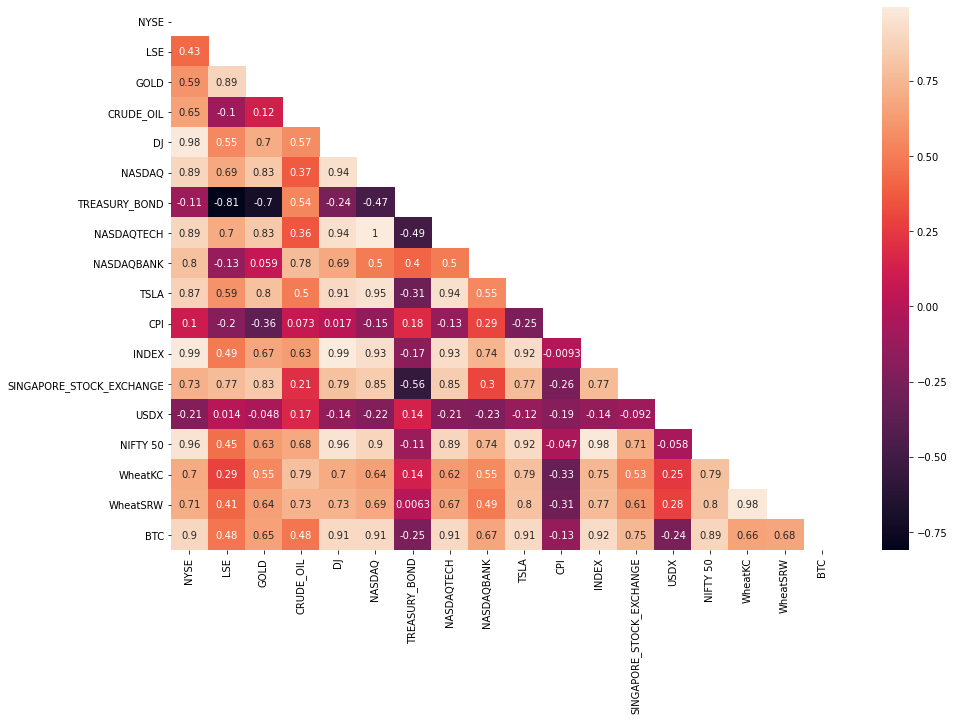

In [162]:
corr=df.corr()
mask=np.triu(np.ones_like(corr,dtype=bool))
plt.figure(figsize=(15,10))
sns.heatmap(corr,mask=mask,annot=True)

In [163]:
X=pd.DataFrame(StandardScaler().fit_transform(X),columns=X.columns,index=y.index)

In [164]:
X.shape

(1642, 17)

In [165]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

In [166]:
X_train

NYSE       LSE      GOLD  CRUDE_OIL        DJ    NASDAQ  \
Date                                                                      
2017-12-31 -0.530754 -1.708593 -1.088855  -0.094005 -0.949582 -1.134022   
2018-01-01 -0.530754 -1.708593 -1.088855  -0.094005 -0.949582 -1.134022   
2018-01-02 -0.530754 -1.708593 -1.088855  -0.094005 -0.949582 -1.134022   
2018-01-03 -0.500879 -1.704442 -1.079082  -0.028579 -0.925426 -1.113958   
2018-01-04 -0.461903 -1.704442 -1.066572  -0.008848 -0.888102 -1.109722   
...              ...       ...       ...        ...       ...       ...   
2022-01-11  1.874057  0.364531  0.885002   0.988624  1.848256  1.653839   
2022-01-12  1.906484  0.438063  0.918623   1.062357  1.857633  1.665796   
2022-01-13  1.854608  0.473643  0.895167   1.035356  1.814373  1.535214   
2022-01-14  1.832728  0.474829  0.876793   1.123628  1.764965  1.564966   
2022-01-15  1.832728  0.474829  0.876793   1.123628  1.764965  1.564966   

            TREASURY_BOND  NASDAQTECH  NASDAQBANK      TSLA       CPI  \
Date                                                                    
2017-12-31       0.688341   -1.133754    0.123231 -0.840004  0.047339   
2018-01-01       0.688341   -1.133754    0.123231 -0.840004  0.047339   
2018-01-02       0.688341   -1.133754    0.123231 -0.840004  0.047339   
2018-01-03       0.666106   -1.106967    0.121037 -0.841868  0.092665   
2018-01-04       0.673518   -1.092043    0.148601 -0.843362 -0.020649   
...                   ...         ...         ...       ...       ...   
2022-01-11      -0.199845    1.718698    2.021782  2.001772  0.115328   
2022-01-12      -0.225787    1.730256    2.037219  2.120580  0.160654   
2022-01-13      -0.243081    1.558898    2.066310  1.908475  0.047339   
2022-01-14      -0.167727    1.628110    2.125766  1.959754  0.115328   
2022-01-15      -0.167727    1.628110    2.125766  1.959754  0.115328   

               INDEX  SINGAPORE_STOCK_EXCHANGE      USDX  NIFTY 50   WheatKC  \
Date                                                                           
2017-12-31 -0.815649                 -1.100021 -1.036513 -0.898343 -0.750077   
2018-01-01 -0.815649                 -1.100021 -1.036513 -0.898343 -0.750077   
2018-01-02 -0.815649                 -1.100021 -1.036513 -0.898343 -0.750077   
2018-01-03 -0.790363                 -1.073810 -0.944968 -0.897967 -0.717995   
2018-01-04 -0.775489                 -1.012651 -1.036513 -0.874802 -0.724412   
...              ...                       ...       ...       ...       ...   
2022-01-11  1.833405                  0.760951  0.076785  1.964790  1.082447   
2022-01-12  1.840842                  0.795898 -0.106304  2.023681  1.011866   
2022-01-13  1.805145                  0.804635 -0.168318  2.040773  0.918187   
2022-01-14  1.796220                  0.839582 -0.056103  2.040002  0.842473   
2022-01-15  1.796220                  0.839582 -0.056103  2.040002  0.842473   

            WheatSRW  
Date                  
2017-12-31 -1.023171  
2018-01-01 -1.023171  
2018-01-02 -1.023171  
2018-01-03 -1.008454  
2018-01-04 -1.020228  
...              ...  
2022-01-11  0.959306  
2022-01-12  0.885718  
2022-01-13  0.820960  
2022-01-14  0.790052  
2022-01-15  0.790052  

[1477 rows x 17 columns]

In [167]:
X_test

NYSE       LSE      GOLD  CRUDE_OIL        DJ    NASDAQ  \
Date                                                                      
2022-01-16  1.832728  0.474829  0.876793   1.123628  1.764965  1.564966   
2022-01-17  1.832728  0.479573  0.876793   1.123628  1.764965  1.564966   
2022-01-18  1.685898  0.474829  0.860373   1.207227  1.631943  1.432581   
2022-01-19  1.613657  0.484317  0.980783   1.286671  1.548747  1.375554   
2022-01-20  1.528669  0.545989  0.978437   1.283556  1.472054  1.311820   
...              ...       ...       ...        ...       ...       ...   
2022-06-25  0.514456  0.579197  0.915887   2.359435  0.685019  0.440407   
2022-06-26  0.514456  0.579197  0.915887   2.359435  0.685019  0.440407   
2022-06-27  0.527461  0.617149  0.893994   2.460687  0.669738  0.411979   
2022-06-28  0.435481  0.666961  0.880702   2.574402  0.549464  0.294597   
2022-06-29  0.398394  0.638497  0.865846   2.471592  0.569618  0.293348   

            TREASURY_BOND  NASDAQTECH  NASDAQBANK      TSLA       CPI  \
Date                                                                    
2022-01-16      -0.167727    1.628110    2.125766  1.959754  0.115328   
2022-01-17      -0.167727    1.628110    2.125766  1.959754  0.115328   
2022-01-18      -0.052844    1.459643    1.993653  1.905492 -0.088634   
2022-01-19      -0.099785    1.402165    1.825345  1.806457 -0.065971   
2022-01-20      -0.092374    1.331558    1.651136  1.808218 -0.111297   
...                   ...         ...         ...       ...       ...   
2022-06-25       1.503645    0.366635    0.243204  1.071989 -3.306702   
2022-06-26       1.503645    0.366635    0.243204  1.071989 -3.306702   
2022-06-27       1.588881    0.323722    0.240672  1.065284 -3.465339   
2022-06-28       1.603705    0.196789    0.208425  0.960823 -3.737290   
2022-06-29       1.464115    0.174505    0.159510  0.925254 -3.941253   

               INDEX  SINGAPORE_STOCK_EXCHANGE      USDX  NIFTY 50   WheatKC  \
Date                                                                           
2022-01-16  1.796220                  0.839582 -0.056103  2.040002  0.842473   
2022-01-17  1.796220                  0.787161 -0.056103  2.059688  0.842473   
2022-01-18  1.680203                  0.708528  0.109269  1.986339  0.984917   
2022-01-19  1.607321                  0.734739  0.044302  1.920660  1.124795   
2022-01-20  1.521052                  0.734739  0.112220  1.852443  1.106829   
...              ...                       ...       ...       ...       ...   
2022-06-25  0.807101                  0.647370  2.607544  1.078611  2.112920   
2022-06-26  0.807101                  0.647370  2.607544  1.078611  2.112920   
2022-06-27  0.799664                  0.717266  2.533718  1.128551  2.011541   
2022-06-28  0.704471                  0.795898  2.702041  1.135377  2.068006   
2022-06-29  0.671748                  0.708528  2.879223  1.116160  2.075705   

            WheatSRW  
Date                  
2022-01-16  0.790052  
2022-01-17  0.790052  
2022-01-18  0.951947  
2022-01-19  1.113842  
2022-01-20  1.077048  
...              ...  
2022-06-25  1.862974  
2022-06-26  1.862974  
2022-06-27  1.746704  
2022-06-28  1.848257  
2022-06-29  1.814406  

[165 rows x 17 columns]

In [168]:
df.shape

(1642, 18)

# Forward feature selection

In [169]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

In [170]:
acc=[]
lr=LinearRegression()
for i in range(1,X.shape[1]+1):
    selector = SFS(LinearRegression(),k_features=i,forward=True,floating=False,scoring = 'r2')
    selector.fit(X_train,y_train)
    features=list(selector.k_feature_names_)
    print(features)
    X_train1=X_train[features]
    X_test1=X_test[features]
    lr.fit(X_train1,y_train)
    acc.append(lr.score(X_test1,y_test))

['TSLA']
['TSLA', 'CPI']
['TSLA', 'CPI', 'INDEX']
['DJ', 'TSLA', 'CPI', 'INDEX']
['DJ', 'TSLA', 'CPI', 'INDEX', 'WheatKC']
['DJ', 'TSLA', 'CPI', 'INDEX', 'NIFTY 50', 'WheatKC']
['DJ', 'NASDAQ', 'TSLA', 'CPI', 'INDEX', 'NIFTY 50', 'WheatKC']
['LSE', 'DJ', 'NASDAQ', 'TSLA', 'CPI', 'INDEX', 'NIFTY 50', 'WheatKC']
['LSE', 'DJ', 'NASDAQ', 'NASDAQTECH', 'TSLA', 'CPI', 'INDEX', 'NIFTY 50', 'WheatKC']
['NYSE', 'LSE', 'DJ', 'NASDAQ', 'NASDAQTECH', 'TSLA', 'CPI', 'INDEX', 'NIFTY 50', 'WheatKC']
['NYSE', 'LSE', 'DJ', 'NASDAQ', 'NASDAQTECH', 'TSLA', 'CPI', 'INDEX', 'USDX', 'NIFTY 50', 'WheatKC']
['NYSE', 'LSE', 'CRUDE_OIL', 'DJ', 'NASDAQ', 'NASDAQTECH', 'TSLA', 'CPI', 'INDEX', 'USDX', 'NIFTY 50', 'WheatKC']
['NYSE', 'LSE', 'CRUDE_OIL', 'DJ', 'NASDAQ', 'NASDAQTECH', 'TSLA', 'CPI', 'INDEX', 'USDX', 'NIFTY 50', 'WheatKC', 'WheatSRW']
['NYSE', 'LSE', 'CRUDE_OIL', 'DJ', 'NASDAQ', 'NASDAQTECH', 'NASDAQBANK', 'TSLA', 'CPI', 'INDEX', 'USDX', 'NIFTY 50', 'WheatKC', 'WheatSRW']
['NYSE', 'LSE', 'CRUDE_OIL', 

In [171]:
acc

[-1.2345941829818408,
 -0.8711416336061242,
 -2.7632080712679965,
 -3.7467882042662497,
 -1.7524653015488596,
 -1.7669499106832904,
 -2.7448758458762454,
 -8.822518177500772,
 -8.058380022664908,
 -7.17619968331759,
 -7.2986044270591695,
 -9.678095914520073,
 -9.51310674303355,
 -0.32971883372525057,
 -0.39905663781086487,
 -1.9397467419422005,
 -2.335234562083471]

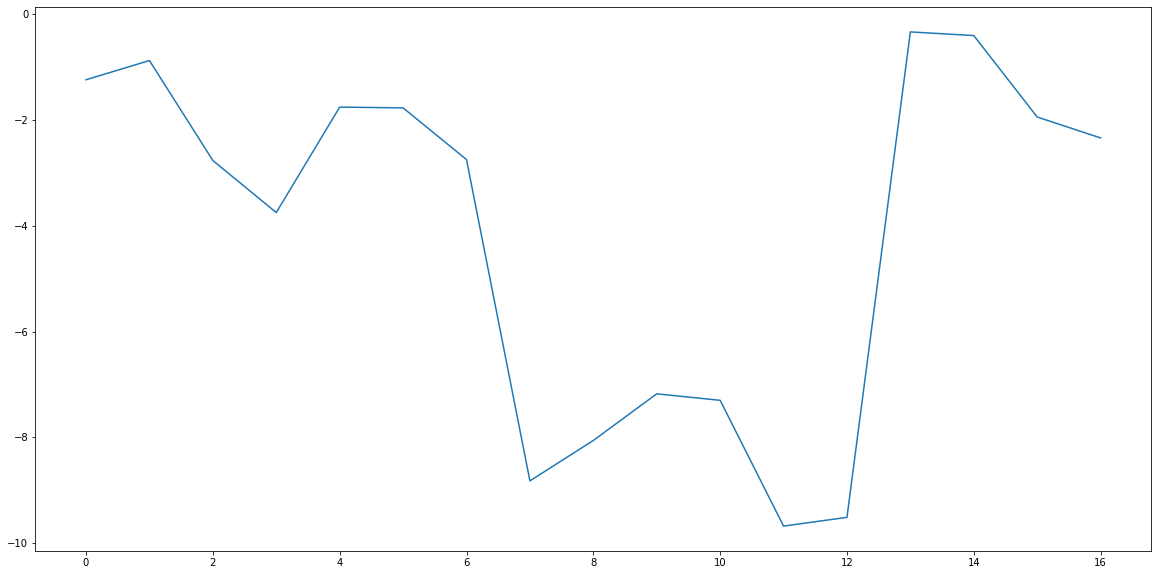

In [172]:
plt.plot(acc)

# Variance Inflation Factor

In [173]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [174]:
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

In [175]:
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]

In [176]:
print(vif_data)

                     feature         VIF
0                       NYSE  563.843512
1                        LSE   14.228232
2                       GOLD   32.289489
3                  CRUDE_OIL   16.011780
4                         DJ  391.059479
5                     NASDAQ  448.481072
6              TREASURY_BOND   30.518323
7                 NASDAQTECH  313.750189
8                 NASDAQBANK   26.501868
9                       TSLA   42.107086
10                       CPI    4.480659
11                     INDEX  534.443429
12  SINGAPORE_STOCK_EXCHANGE    9.509517
13                      USDX    8.301983
14                  NIFTY 50   41.885192
15                   WheatKC  101.862455
16                  WheatSRW   79.305846


# Trying to select features with reatively less VIF

In [177]:
vif_data.sort_values(by="VIF")

feature         VIF
10                       CPI    4.480659
13                      USDX    8.301983
12  SINGAPORE_STOCK_EXCHANGE    9.509517
1                        LSE   14.228232
3                  CRUDE_OIL   16.011780
8                 NASDAQBANK   26.501868
6              TREASURY_BOND   30.518323
2                       GOLD   32.289489
14                  NIFTY 50   41.885192
9                       TSLA   42.107086
16                  WheatSRW   79.305846
15                   WheatKC  101.862455
7                 NASDAQTECH  313.750189
4                         DJ  391.059479
5                     NASDAQ  448.481072
11                     INDEX  534.443429
0                       NYSE  563.843512

Out of 17,we are taking 10 features 

In [178]:
X

NYSE       LSE      GOLD  CRUDE_OIL        DJ    NASDAQ  \
Date                                                                      
2017-12-31 -0.530754 -1.708593 -1.088855  -0.094005 -0.949582 -1.134022   
2018-01-01 -0.530754 -1.708593 -1.088855  -0.094005 -0.949582 -1.134022   
2018-01-02 -0.530754 -1.708593 -1.088855  -0.094005 -0.949582 -1.134022   
2018-01-03 -0.500879 -1.704442 -1.079082  -0.028579 -0.925426 -1.113958   
2018-01-04 -0.461903 -1.704442 -1.066572  -0.008848 -0.888102 -1.109722   
...              ...       ...       ...        ...       ...       ...   
2022-06-25  0.514456  0.579197  0.915887   2.359435  0.685019  0.440407   
2022-06-26  0.514456  0.579197  0.915887   2.359435  0.685019  0.440407   
2022-06-27  0.527461  0.617149  0.893994   2.460687  0.669738  0.411979   
2022-06-28  0.435481  0.666961  0.880702   2.574402  0.549464  0.294597   
2022-06-29  0.398394  0.638497  0.865846   2.471592  0.569618  0.293348   

            TREASURY_BOND  NASDAQTECH  NASDAQBANK      TSLA       CPI  \
Date                                                                    
2017-12-31       0.688341   -1.133754    0.123231 -0.840004  0.047339   
2018-01-01       0.688341   -1.133754    0.123231 -0.840004  0.047339   
2018-01-02       0.688341   -1.133754    0.123231 -0.840004  0.047339   
2018-01-03       0.666106   -1.106967    0.121037 -0.841868  0.092665   
2018-01-04       0.673518   -1.092043    0.148601 -0.843362 -0.020649   
...                   ...         ...         ...       ...       ...   
2022-06-25       1.503645    0.366635    0.243204  1.071989 -3.306702   
2022-06-26       1.503645    0.366635    0.243204  1.071989 -3.306702   
2022-06-27       1.588881    0.323722    0.240672  1.065284 -3.465339   
2022-06-28       1.603705    0.196789    0.208425  0.960823 -3.737290   
2022-06-29       1.464115    0.174505    0.159510  0.925254 -3.941253   

               INDEX  SINGAPORE_STOCK_EXCHANGE      USDX  NIFTY 50   WheatKC  \
Date                                                                           
2017-12-31 -0.815649                 -1.100021 -1.036513 -0.898343 -0.750077   
2018-01-01 -0.815649                 -1.100021 -1.036513 -0.898343 -0.750077   
2018-01-02 -0.815649                 -1.100021 -1.036513 -0.898343 -0.750077   
2018-01-03 -0.790363                 -1.073810 -0.944968 -0.897967 -0.717995   
2018-01-04 -0.775489                 -1.012651 -1.036513 -0.874802 -0.724412   
...              ...                       ...       ...       ...       ...   
2022-06-25  0.807101                  0.647370  2.607544  1.078611  2.112920   
2022-06-26  0.807101                  0.647370  2.607544  1.078611  2.112920   
2022-06-27  0.799664                  0.717266  2.533718  1.128551  2.011541   
2022-06-28  0.704471                  0.795898  2.702041  1.135377  2.068006   
2022-06-29  0.671748                  0.708528  2.879223  1.116160  2.075705   

            WheatSRW  
Date                  
2017-12-31 -1.023171  
2018-01-01 -1.023171  
2018-01-02 -1.023171  
2018-01-03 -1.008454  
2018-01-04 -1.020228  
...              ...  
2022-06-25  1.862974  
2022-06-26  1.862974  
2022-06-27  1.746704  
2022-06-28  1.848257  
2022-06-29  1.814406  

[1642 rows x 17 columns]

In [179]:
vif_data.sort_values(by="VIF")["feature"][:11]

10                         CPI
13                        USDX
12    SINGAPORE_STOCK_EXCHANGE
1                          LSE
3                    CRUDE_OIL
8                   NASDAQBANK
6                TREASURY_BOND
2                         GOLD
14                    NIFTY 50
9                         TSLA
16                    WheatSRW
Name: feature, dtype: object

In [180]:
r2_score=[]
for i in range(1,15):
    X_new=X[vif_data.sort_values(by="VIF")["feature"][:i]]
    X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.1, shuffle=False)
    lr=LinearRegression()
    lr.fit(X_train,y_train)
    r2_score.append(lr.score(X_test,y_test))

In [181]:
r2_score

[-5.536674453651552,
 -16.002434078408996,
 -3.819514509691108,
 -3.0242570134332203,
 -43.23049697162859,
 -8.650933843797407,
 -2.674913552163526,
 -4.120652819731805,
 -1.515299394920607,
 -0.614274006153769,
 -0.5269928467878775,
 -0.29616588237810193,
 -1.7668828402909842,
 -1.5058676253964385]

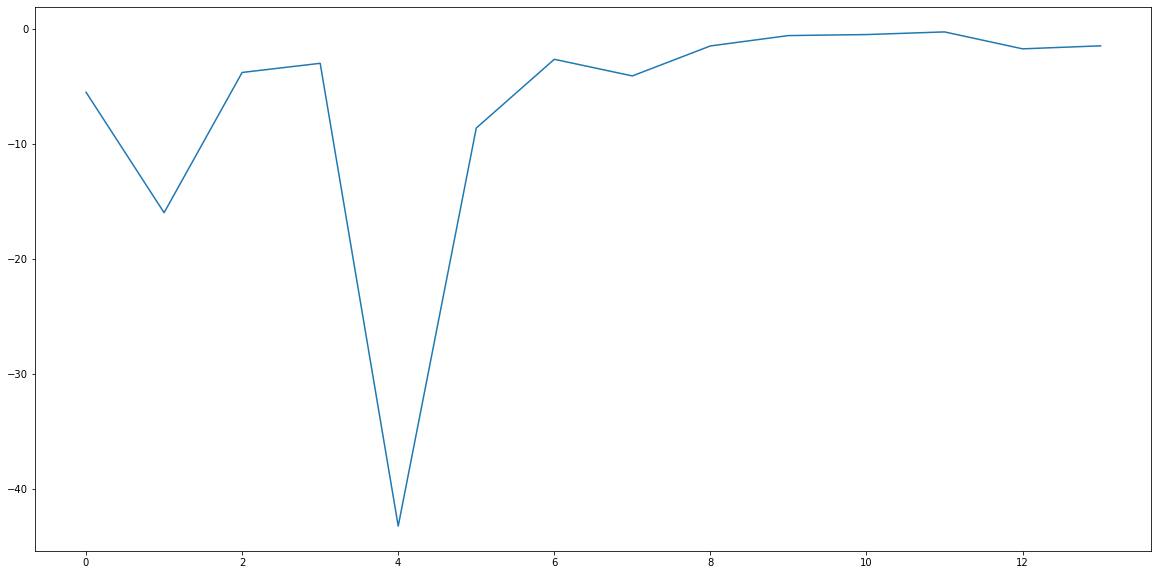

In [182]:
plt.plot(r2_score)

# Trying Ridge and Lasso Regression

In [183]:
from sklearn.linear_model import Ridge as ridge,Lasso as lasso

In [184]:
a=np.logspace(-7,2,70)
a

array([1.00000000e-07, 1.35031404e-07, 1.82334800e-07, 2.46209240e-07,
       3.32459793e-07, 4.48925126e-07, 6.06189899e-07, 8.18546731e-07,
       1.10529514e-06, 1.49249555e-06, 2.01533769e-06, 2.72133877e-06,
       3.67466194e-06, 4.96194760e-06, 6.70018750e-06, 9.04735724e-06,
       1.22167735e-05, 1.64964807e-05, 2.22754295e-05, 3.00788252e-05,
       4.06158599e-05, 5.48441658e-05, 7.40568469e-05, 1.00000000e-04,
       1.35031404e-04, 1.82334800e-04, 2.46209240e-04, 3.32459793e-04,
       4.48925126e-04, 6.06189899e-04, 8.18546731e-04, 1.10529514e-03,
       1.49249555e-03, 2.01533769e-03, 2.72133877e-03, 3.67466194e-03,
       4.96194760e-03, 6.70018750e-03, 9.04735724e-03, 1.22167735e-02,
       1.64964807e-02, 2.22754295e-02, 3.00788252e-02, 4.06158599e-02,
       5.48441658e-02, 7.40568469e-02, 1.00000000e-01, 1.35031404e-01,
       1.82334800e-01, 2.46209240e-01, 3.32459793e-01, 4.48925126e-01,
       6.06189899e-01, 8.18546731e-01, 1.10529514e+00, 1.49249555e+00,
      

In [185]:
ridge_score=[]
lasso_score=[]
for i in a:
    r=ridge(alpha=i)
    l=lasso(alpha=i)
    r.fit(X_train,y_train)
    l.fit(X_train,y_train)
    ridge_score.append(r.score(X_test,y_test))
    lasso_score.append(l.score(X_test,y_test))

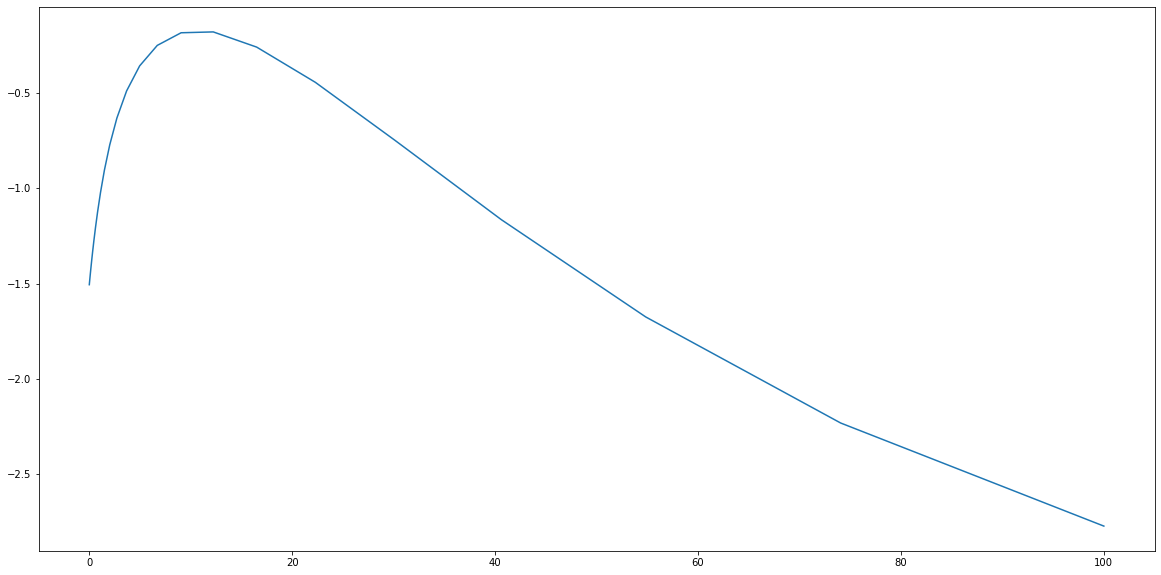

In [186]:
plt.plot(a,ridge_score)


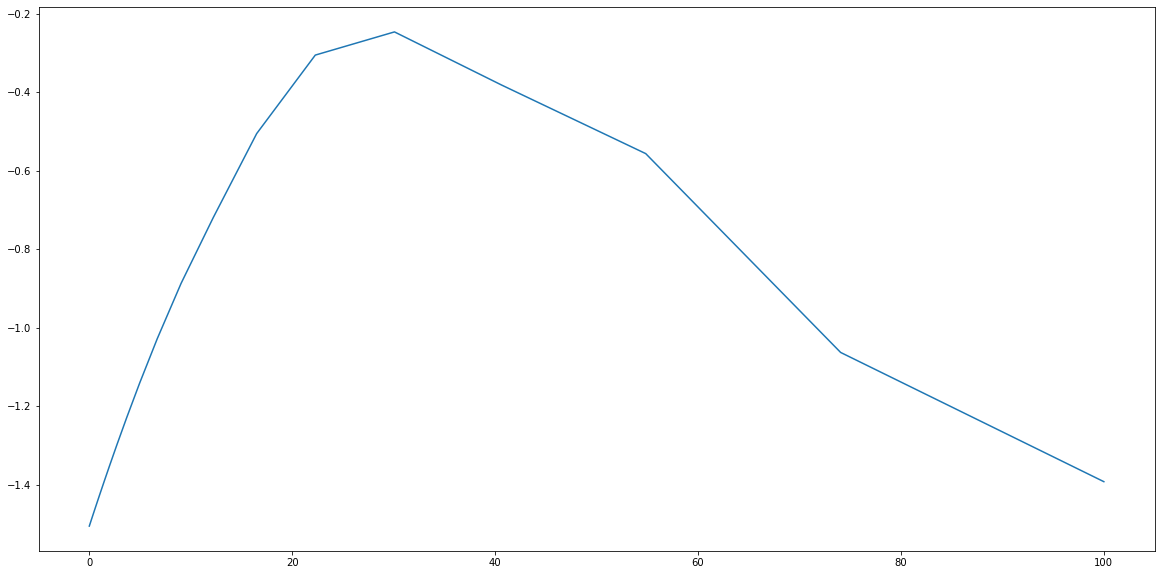

In [187]:
plt.plot(a,lasso_score)

We can see that Multivariate Regression is **not giving us good results**. So if we want to predict the price of Bitcoin, it is not the best available way(with the predictors that we have used). **Presence of multicolinearity** is a very serious issue here. We get better results when we are **using bivariate regression. NYSE,DowJones,NASDAQ,NASDAQ100TECH** have given us relatively good results in bivariate regression

# Key conclusions

Based on our analysis, **ARIMA gave better results** on predicting Bitcoin prices than bivariate regression,multiple regression and ridge and lasso regression. So using ARIMA models a person can gain some idea about the possible movement in the price of Bitcoin in short term, like 1 or 2 days.This may be beneficial for short term crypto traders.

The **causality relationship between the price changes of Etherium and Bitcoin is bidirectional**

Bitcoin is **not a good hedging option**. **The sentiments that govern some of the major stock markets also affects the prices of Bitcoin**. So, there is a high association in price movements between Bitcoin and few of the major stock markets in the world.So if somone invests in Bitcoin thinking that it will go up when the market will go down then he would be disappointed. While this is true, one can make **some reasonable speculations about Bitcoin prices by seeing the price movements of NYSE,DowJones,NASDAQ,Tesla, Nifty50**.

